# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID (index) for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : contains ID and output for each data

In [145]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random
import math

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import tpot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [146]:
# !pip install skfeature-chappers
# !pip install mlxtend
# !pip --version
# !pip install imblearn
# !conda install -c conda-forge imbalanced-learn
# conda install -c conda-forge tqdm
# conda install mlxtend

# conda config --add channels conda-forge
# conda install hyperopt

# conda config --add channels conda-forge
# conda config --set channel_priority strict
# conda install auto-sklearn
# conda install -c conda-forge tpot



Show the installed packages with their versions

In [147]:
!conda list

# packages in environment at /home/bayzid/anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2020.07                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.0.0                    pypi_0    pypi
adjusttext                0.7.3                    pypi_0    pypi
alabaster                 0.7.13             pyhd8ed1ab_0    conda-forge
alignment-c               1.0.0                    pypi_0    pypi
anaconda                  custom                   py37_1  
anaconda-client           1.12.0             pyhd8ed1ab_0    conda-forge
anaconda-navigator        2.1.0            py37h06a4308_0  
anaconda-project          0.11.1             pyhd8ed1ab_0    conda-forge
anyio                     3.7.1              pyhd8ed1ab_0    conda-forge
ar

In [148]:
random_seed = 42 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

In [149]:
yrs = 'nores'
progression = ""

In [150]:
Final_Samples_path = './Final Samples/Final_Samples_' + yrs + '.json'
if progression == "from_cn":
    Final_Samples_path = './Final Samples/final_samples_progression_from_cn_' + yrs + '.json'
if progression == "from_mci":
    Final_Samples_path = './Final Samples/final_samples_progression_from_mci_' + yrs + '.json'
if progression == "from_non_ad":
    Final_Samples_path = './Final Samples/Final_Samples_4yrs_transition_from_Non_dementia.json'
print(Final_Samples_path)
Final_Samples = json.load(open(Final_Samples_path, 'r')) 
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix_with_AD_PRS.npy').astype(np.float32)
# normalize feature matrix
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
# PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
num_features=PRS_orig_feature_matrix.shape[1]
print(len( usable_samples_ADNI ) )
print(num_features)

./Final Samples/Final_Samples_nores.json
1816
53


In [77]:
# covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",covar_df.shape)
print( covar_df[['AGE', 'PTGENDER']].shape, covar_df[['AGE', 'PTGENDER']].dropna().shape ) 
# PC - Principal Component

# trying to normalize AGE with having max age of 100
covar_df['AGE'] = covar_df['AGE'] / 100.0
print( covar_df.head() )

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER    AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  0.691  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  0.707  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  0.655  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  0.714  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0

Covar for ADNI Plink

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [78]:
num_features = 53
hidden = 4
hidden_dimension = 32

In [79]:
# take the first num_features column from PRS_feature_matrix
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 53)


Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [80]:
# positive samples - output true
# negative samples - output false
len_positive_samples = 0
len_negative_samples = 0
for x in Final_Samples:
    if x[1] == 1 :
        len_positive_samples += 1
    else :
        len_negative_samples += 1
        
print(len(Final_Samples))
print(len_positive_samples)
print(len_negative_samples)

1798
654
1144


In [81]:
data_dictionary = {}

with open('short_column_names.txt', 'r') as file:
    for line in file:
#         print(line)
        length = len( line.strip().split(';') )
#         print(length)
        if  length == 2:
            long_name, short_form = line.strip().split('; ')
            data_dictionary[long_name] = short_form
        else:
            print( line )

            # Find the last semicolon in the text
            last_semicolon_index = line.rfind(';')

            # Split the text into two parts based on the last semicolon
            long_name = line[:last_semicolon_index]
            short_form = line[last_semicolon_index + 1:]
            print( long_name, short_form)
            short_form = short_form.rstrip("\n")

            data_dictionary[long_name] = short_form
            

# Example usage
key = "Hearing difficulty/problems with background noise"
# print(data_dictionary.keys() )
if key in data_dictionary:
    print(data_dictionary[key])  # Output: "Hearing Difficulty"
else:
    print("Key not found in the dictionary.")


Nitrogen oxides air pollution; 2010;Nitrogen Oxides Air Pollution

Nitrogen oxides air pollution; 2010 Nitrogen Oxides Air Pollution

Particulate matter air pollution 2.5-10um; 2010;Particulate Matter Air Pollution

Particulate matter air pollution 2.5-10um; 2010 Particulate Matter Air Pollution

Hearing Difficulty


# Combining covar data with PRS Feature Matrix

In [82]:
# cnt = number of missing IDs for which covar data doesn't exist
cnt = 0
print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# adding ( total columns - 2 ) of covar_df , excluding FID, IID
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    # taking from the PCs, skipping the first two columns of IID, FID
    covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
    # shape[0] = 1 means a row is found in covar for the following sample ID
    # if not, that means no covar data exists for the sample in usable_samples_ADNI
    if covar.shape[0] != 1:
#         print(covar.shape)
        print(sample)
        cnt += 1
        continue
    # Adding the covar values to the feature matrix
    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


print("Count of missing samples for covar data : ", cnt)
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

Before adding covar_df columns, shape :  (1816, 53)
Before adding covar_df columns, shape :  (1816, 65)
ADNI3_037_S_6125
ADNI3_024_S_6005
ADNI3_002_S_6066
ADNI3_011_S_6303
ADNI3_053_S_6598
7_098_S_0160
8_027_S_0256
26_052_S_1346
47_072_S_2027
51_016_S_0702
64_027_S_2219
71_027_S_1045
75_068_S_4174
82_007_S_2058
86_100_S_0296
96_041_S_1418
222_141_S_0915
239_153_S_4372
313_068_S_4340
315_129_S_4396
324_129_S_4371
379_037_S_4146
387_130_S_4405
388_126_S_4507
397_022_S_1097
445_021_S_4254
446_137_S_4299
449_006_S_0498
462_098_S_4018
477_082_S_1256
480_098_S_2079
487_002_S_4237
492_041_S_4271
522_068_S_4332
533_127_S_4500
555_099_S_4463
583_141_S_2333
589_099_S_1034
630_022_S_2087
637_033_S_0922
648_137_S_0972
655_021_S_2150
665_027_S_0074
675_014_S_0658
682_099_S_2146
691_037_S_0377
695_057_S_1269
719_023_S_4035
740_137_S_0459
753_016_S_1326
763_100_S_0047
801_123_S_4096
196_037_S_0454
210_036_S_0673
263_072_S_1380
268_141_S_1004
26_128_S_0522
289_023_S_0126
296_029_S_0914
298_021_S_0178


# Create directory for saving shap figures

In [83]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [84]:
age_zero = 0
age_zero_idx = []
for i in range( len(FEATURE_MATRIX) ):
    if FEATURE_MATRIX[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
        
print(age_zero)

234


# Indices of features to consider

In [85]:


# feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# naeem modified
print(FEATURE_MATRIX.shape[1])
last_idx = FEATURE_MATRIX.shape[1] - 1
feature_indices_to_consider = list(range(num_features))  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# remove_indices = [1, 2, 3]
# for i in remove_indices:
#     feature_indices_to_consider.remove(i)

# feature_indices_to_consider = list(range(23, 36))

# feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# feature_indices_to_consider = [9, 10, 28, 34, 46]

print(feature_indices_to_consider)
# feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# feature_indices_to_consider = [2, 26, 32, 45]


65
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 63, 64]


# Functions & Classes

In [86]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

**Modifications**
1. Added relu in the hidden layers and sigmoid in the output layer as activation functions
2. Added dropout in the hidden layers

In [87]:
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            # added by Mashiat
            features = self.dropout(features, p=self.drop_probab)
            features = self.relu( features )
            ####################
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [88]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (fc1): Linear(in_features=55, out_features=32, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [89]:
class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [90]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [91]:
# random samples : sample test dataset taking equal number of positive & negative outputs
#                 args : 
#                         total_folds : fold number for splitting
#                         random_seed : seed value for randomization
#                 return :
#                         N_splits : test dataset splitted according to fold numbers
                        
def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open(Final_Samples_path, 'r')) 
    positive_samples = Final_Samples[:len_positive_samples]
    negative_samples = Final_Samples[len_positive_samples:]
    min_len = min( len(positive_samples), len(negative_samples))
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    print("min length : ", min_len)
    Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
    random.shuffle(Final_Samples)
    print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
    Final_Samples = np.array(Final_Samples)

#   -----------------------------------------------------------------------
#     positive_samples = Final_Samples[:654]
#     negative_samples = Final_Samples[654:]
#     if random_seed is not None: 
#         random.seed(random_seed * 2)
#     random.shuffle(positive_samples)
#     random.shuffle(negative_samples)
#     Final_Samples = positive_samples[:500] + negative_samples[:500]
#     if random_seed is not None: 
#         random.seed(random_seed)
#     random.shuffle(Final_Samples)
#     Final_Samples = np.array(Final_Samples)
# --------------------------------------------------------------------------
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

# generate_datasets : get train, validation & test datasets
#                 args : 
#                         N_splits : data splitted according to folds; output of random samples
#                         fold_num : fold_num for test dataset
#                         random_seed : seed value for randomization
#                 return :
#                         train_set, test_set, val_set : datasets
def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    # take all as training dataset, leaves nothing for validation - multiply shpae by 1
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    # normalize dataset
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
#     print(len(train_set))
#     print(len(val_set))
#     print(len(test_set))
    return train_set, val_set, test_set



# generate_loader : get train, validation & test as torch dataset
#                 args : 
#                         train_set, test_set, val_set : datasets
#                 returns :
#                         train, val & test torch datasets
def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

# train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
# val_set.feature_matrix.shape

In [92]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    


**epoch function for LOOCV**

Without precision, recall, ROC, AUC 

In [93]:
def loocv_epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
#     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
#     auroc = roc_auc_score(true, pred)
#     p, r, thresholds = precision_recall_curve(true, pred)
#     auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    

# usable_samples_ADNI 

In [94]:
# usable_indices : take indices from usable_samples_ADNI which are in Final_Samples
# usable_features : take the part of feature matrix with usable_indices( rows )
#                   and feature_indices_to_consider ( columns )

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)


1798
1798
Shape of usable features :  (1798, 55)


# Removing age values with 0

In [95]:
# removing age with value 0
#--------------------------------------------------------------------------------
age_zero = 0
age_zero_idx = []
for i in range(len(usable_features)):
    if usable_features[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
print(len(age_zero_idx))
print(usable_features.shape, len( Final_Samples ) )
usable_features = np.delete(usable_features, age_zero_idx, axis = 0)
Final_Samples = np.delete(Final_Samples, age_zero_idx, axis = 0)
print(usable_features.shape, len( Final_Samples ) )
print(Final_Samples[0])
#--------------------------------------------------------------------------------

231
(1798, 55) 1798
(1567, 55) 1567
['791_020_S_0213' '1']


# usable_labels : output

In [96]:
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))

Length of usable labels :  1567


# Read all traits from json file 

In [97]:
all_traits = json.load(open('traits_map_w_ad.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(traits)

['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzhei

# Get traits corresponding to features

In [98]:
print(PRS_orig_feature_matrix.shape[1])
# print(feature_indices_to_consider)

print(len(traits))
print(feature_indices_to_consider)

# check if age and gender is included
# if they are included, their index will be larger than the original feature matrix
if any(y >PRS_orig_feature_matrix.shape[1] for y in feature_indices_to_consider):
#     features = feature_indices_to_consider.copy()
#     age_include = False
#     gender_include = False
#     print(features[-2])
#     if(features[-2] == PRS_orig_feature_matrix.shape[1] + 8):
#         print("gender_include")
#         features.pop(-2)
#         gender_include = True
#     print(features[-1])
#     if(features[-1] == PRS_orig_feature_matrix.shape[1] + 9):
#         print("age include")
#         features.pop(-1)
#         age_include = True
    
#     print(features)
#     traits = [ traits[i] for i in features]
#     if gender_include == True:
#         traits.append("gender")
#     if age_include == True:
#         traits.append("age")
    
#     traits.append("output prediction")
    traits.append("gender")
    traits.append("age")
else:
    # not included - age, gender
    traits = [ traits[i] for i in feature_indices_to_consider]
print(traits)


53
53
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 63, 64]
['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', '

# Panda dataframe conversion

In [99]:
print(usable_features.shape)
print(usable_labels.shape)
total_features = np.c_[ usable_features, usable_labels ]
# print(total_features.shape)
# print(num_features)
# column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
column_list = feature_indices_to_consider + [num_features]
# print( column_list )

df = pd.DataFrame(total_features, columns = column_list )

# turn column names to strings
# df.columns = df.columns.astype(str)

# assign traits as column names
column_names = traits.copy()
column_names.append('output')
df.columns = column_names
# print( df.columns )

# dropping last / output column in df
df_X = df.iloc[: , :-1]
# taking the output column of df
df_Y = df.iloc[: , -1]

print( df.head() )
# print( df_X.head() )
# print( df_Y.head() )



(1567, 55)
(1567,)
   Non-cancer illness code, self-reported: type 2 diabetes  \
0                                          -0.103353         
1                                           1.469201         
2                                          -0.705754         
3                                           1.182782         
4                                           0.536634         

   Ever had known person concerned about, or recommend reduction of, alcohol consumption: No  \
0                                           1.048889                                           
1                                          -1.180738                                           
2                                           1.188120                                           
3                                           0.674291                                           
4                                           0.824905                                           

   Ever had known person concer

In [100]:
df.rename(columns=data_dictionary, inplace=True)
print( df.head() )


   Type 2 Diabetes  No recommendation of alcohol consumption  \
0        -0.103353                                  1.048889   
1         1.469201                                 -1.180738   
2        -0.705754                                  1.188120   
3         1.182782                                  0.674291   
4         0.536634                                  0.824905   

   Recommendation of alcohol consumption - Yes, Not Last Year  \
0                                           1.312935            
1                                           0.603427            
2                                          -0.198552            
3                                          -0.277919            
4                                          -0.070509            

   Recommendation of alcohol consumption  Total Cholesterol  HDL Cholesterol  \
0                               0.660730          -1.455384         2.025420   
1                              -0.445463           0.927659     

# Drop Age and Gender

In [101]:
# df = df.drop(['Age', 'Gender'], axis = 1)
# print(df.columns)

In [102]:
print(df.shape)
if progression != '':
    df.to_csv('adni_' + yrs + '_' + progression + '.csv')
else:
    df.to_csv('adni_' + yrs + '.csv' )

(1567, 56)


# Get equal amount of positive & negative data

In [103]:
print( df['output'].value_counts() )

ones = df[df['output'] == 1]
zeros = df[df['output'] == 0]
min_len = min( len(ones), len(zeros) ) 

ones = ones.iloc[:min_len, :]
zeros = zeros.iloc[:min_len, :]

df = ones.append(zeros, ignore_index=True)
print(df.shape)

0.0    991
1.0    576
Name: output, dtype: int64
(1152, 56)


In [104]:
if progression != '':
    df.to_csv('adni_balanced_'+yrs+'_' + progression + '.csv')
else:
    print("Hello")
    df.to_csv('adni_balanced_' + yrs + '.csv')

Hello


# SMOTE Analysis to oversample data

https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc#:~:text=SMOTE%20is%20an%20over%2Dsampling,its%20%E2%80%9Ck%E2%80%9D%20nearest%20neighbors.

In [105]:

def smote(x, y):
    # Synthetic Minority Over-samping Technique
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    # Borderline-SMOTE
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    # m_neighbors : number of neighbors to consider to determine if a sample is danger
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy=1, 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y
    
def adasyn(x, y):
    # Adaptive Synthetic
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # n_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    n_neighbors = math.ceil(sum(y) * 0.01)
    
    adasyn = ADASYN(sampling_strategy=1,
                   n_neighbors=n_neighbors)
    x, y = adasyn.fit_resample(x, y)

    return x, y

In [106]:
# # dropping last / output column in df
# shuffled_X = shuffled.iloc[: , :-1]
# # taking the output column of df
# shuffled_Y = shuffled.iloc[: , -1]
# print(df.shape)
# df_X_new, df_Y_new = bordersmote(df_X, df_Y)
# print( df_X_new.shape, df_Y_new.shape )

# df = df_X_new
# df['output'] = df_Y_new
# print(df.shape)


In [107]:
print( df['output'].value_counts() )
print(df.head())

# ones = df[df['output'] == 1]
# zeros = df[df['output'] == 0]
# min_len = min( len(ones), len(zeros) ) 

# ones = ones.iloc[:min_len, :]
# zeros = zeros.iloc[:min_len, :]

# df = ones.append(zeros, ignore_index=True)
# print(df.shape)

1.0    576
0.0    576
Name: output, dtype: int64
   Type 2 Diabetes  No recommendation of alcohol consumption  \
0        -0.103353                                  1.048889   
1         1.469201                                 -1.180738   
2        -0.705754                                  1.188120   
3         1.182782                                  0.674291   
4         0.536634                                  0.824905   

   Recommendation of alcohol consumption - Yes, Not Last Year  \
0                                           1.312935            
1                                           0.603427            
2                                          -0.198552            
3                                          -0.277919            
4                                          -0.070509            

   Recommendation of alcohol consumption  Total Cholesterol  HDL Cholesterol  \
0                               0.660730          -1.455384         2.025420   
1              

# Shuffling dataframe

**Dropping alcohol recommended columns**

In [108]:
# # keep the index same
# shuffled = df.sample(frac=1)
# print( shuffled.head() )

# reset the index
shuffled = df.sample(frac=1, random_state = 1).reset_index()
# print(shuffled.columns)
shuffled = shuffled.drop( ['index'], axis = 1 )


# #  dropping alcohol recommended columns
# shuffled = shuffled.drop(['Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year'], axis = 1)
# shuffled = shuffled.drop(['Non-cancer illness code, self-reported: anxiety/panic attacks', 'Sleeplessness / insomnia', 'Non-cancer illness code, self-reported: type 2 diabetes', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", "Alcohol intake frequency", 'Other meat intake' ], axis = 1)

print( shuffled.head() )



   Type 2 Diabetes  No recommendation of alcohol consumption  \
0        -1.907915                                 -0.063395   
1         1.289058                                 -0.502094   
2        -0.381645                                  0.041821   
3         0.114929                                  0.221493   
4         0.503239                                 -0.063222   

   Recommendation of alcohol consumption - Yes, Not Last Year  \
0                                           0.233013            
1                                           0.518958            
2                                          -1.287524            
3                                          -0.320702            
4                                          -0.696554            

   Recommendation of alcohol consumption  Total Cholesterol  HDL Cholesterol  \
0                              -0.189565          -1.677074        -0.973992   
1                              -0.771783          -2.197081     

In [109]:
if progression != '':
    shuffled.to_csv('adni_shuffled_balanced_'+yrs+'_' + progression + '.csv')
else:
    shuffled.to_csv('adni_shuffled_balanced_' + yrs + '.csv' )

In [110]:
# usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

# print("Usable Features : ", usable_features[:2])

# print(usable_features.shape)

# Combining Illness of Father & Mother having Alzheimer

Previously data showed a negative correlation with both of these factors, which shouldn't be. We will now try to combine both risk scores by averaging it and use is as a new feature, descarding the previous two. This new feature will represent the risk score of a parent having Alzheimer.

In [111]:
# shuffled['Parent having Alzheimer'] = shuffled[["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]].max(axis=1)
# shuffled[["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", "Parent having Alzheimer"]].head()

In [112]:
# shuffled = shuffled.drop(['Illnesses of mother: Alzheimer\'s disease/dementia', 'Illnesses of father: Alzheimer\'s disease/dementia'], axis = 1 )
# print( shuffled.head() )

In [113]:
# index=shuffled.columns.get_loc("output")
# temp_cols = shuffled.columns.tolist()
# print(index)
# new_cols= temp_cols[0 : index] + temp_cols[index+1 : ] + temp_cols[index : index + 1 ]
# shuffled = shuffled[new_cols]
# print( shuffled.head() )

# X, Y differentiate

In [114]:
# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
# taking the output column of df
shuffled_Y = shuffled.iloc[: , -1]

# Feature Analysis

Type 2 Diabetes


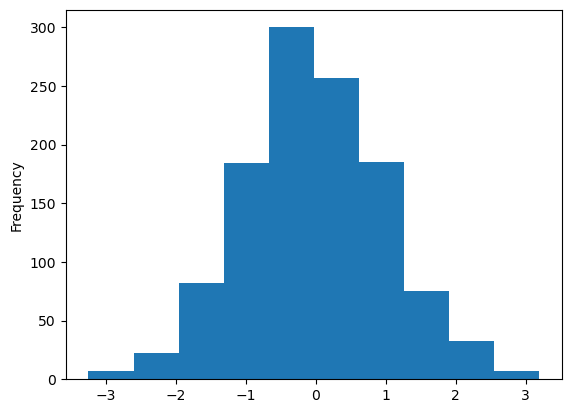

No recommendation of alcohol consumption


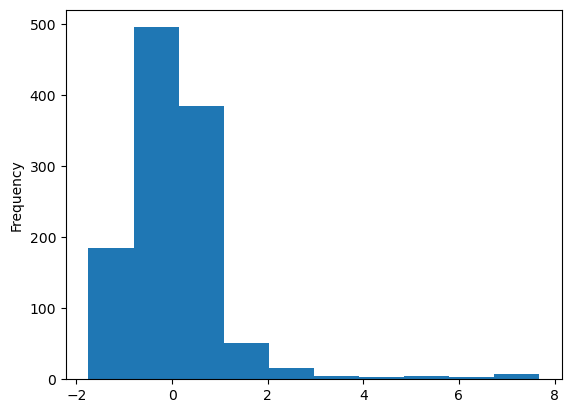

Recommendation of alcohol consumption - Yes, Not Last Year


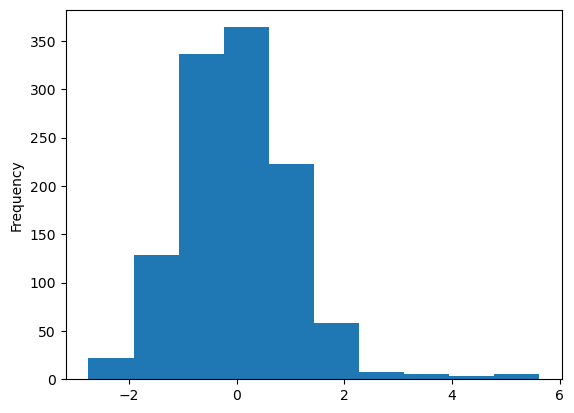

Recommendation of alcohol consumption


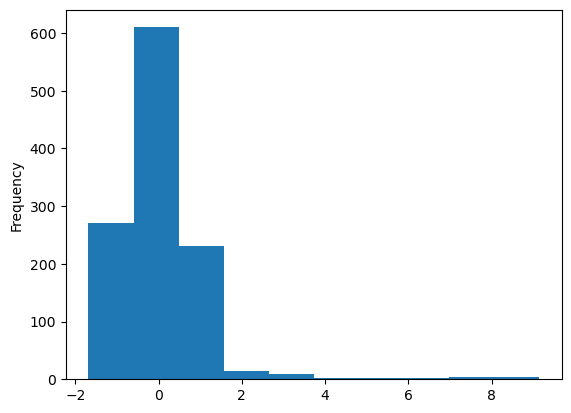

Total Cholesterol


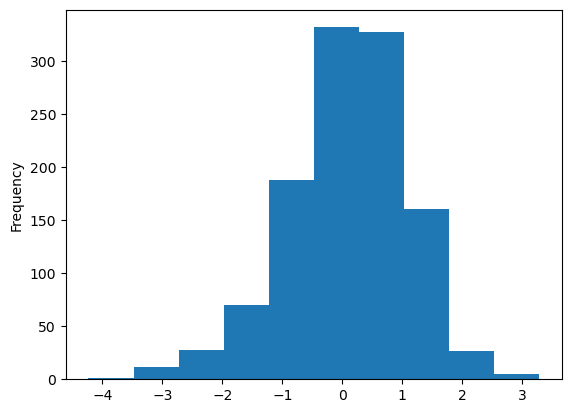

HDL Cholesterol


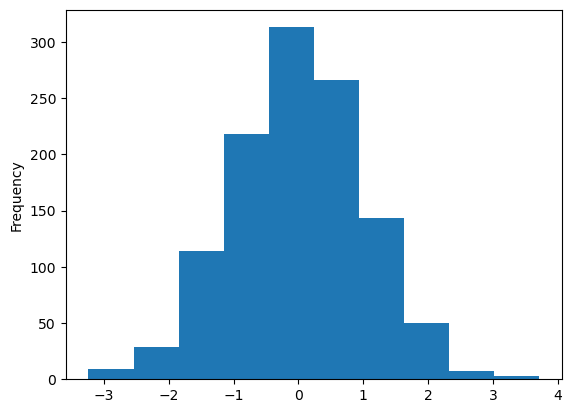

LDL Cholesterol


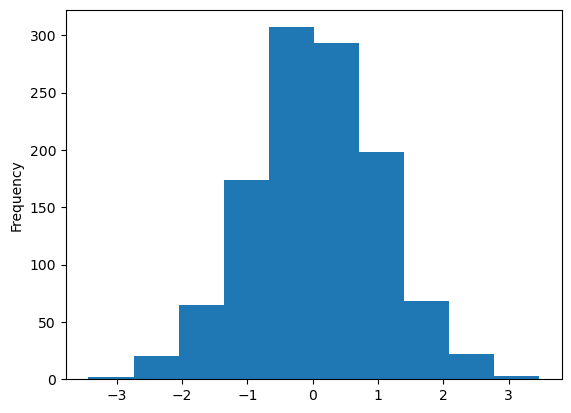

Triglycerides


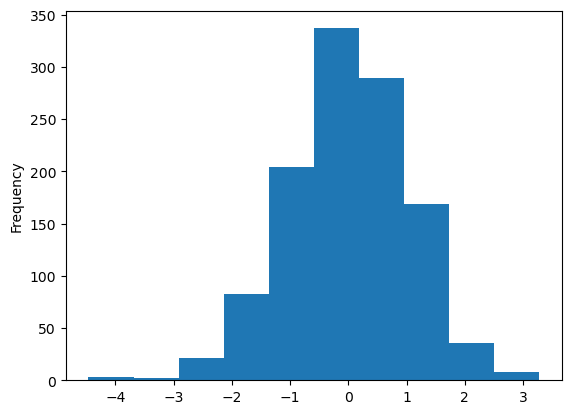

Cigarettes per Day


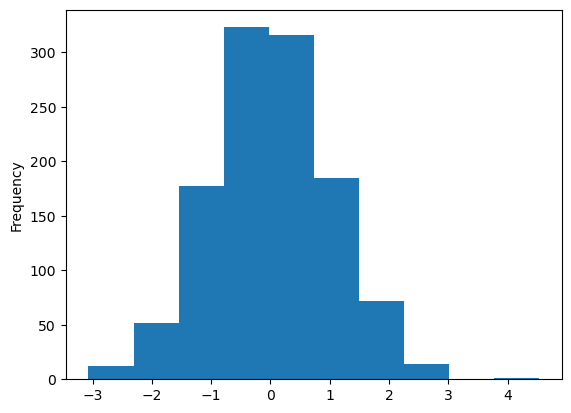

Systolic blood pressure


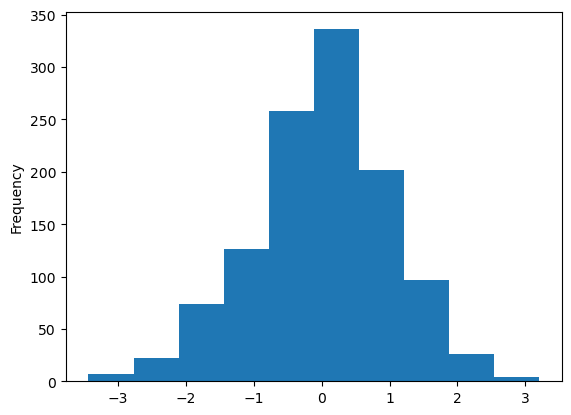

Diastolic blood pressure


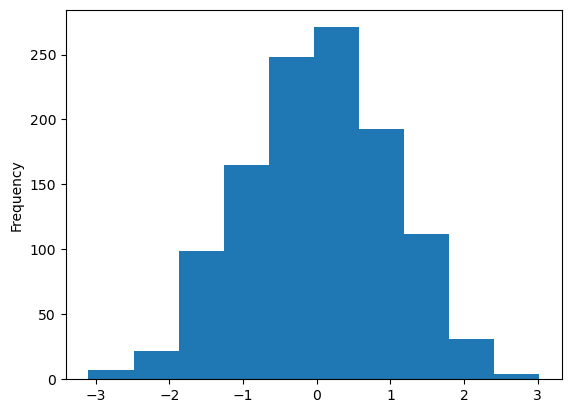

Hearing Difficulty - Yes


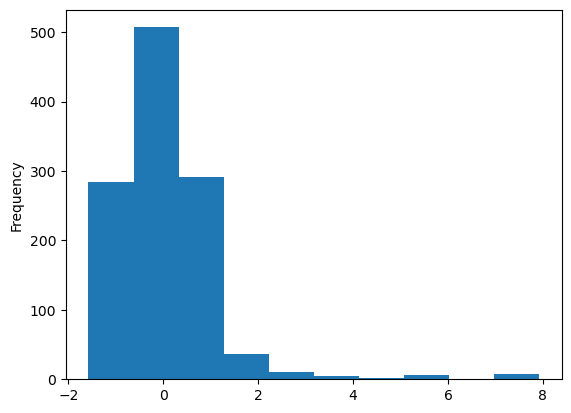

Depression


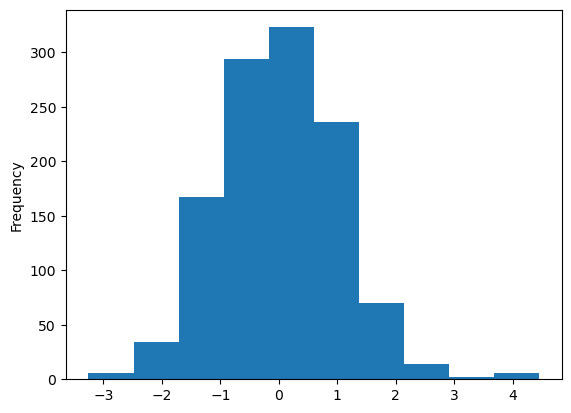

Non-Oily Fish Intake


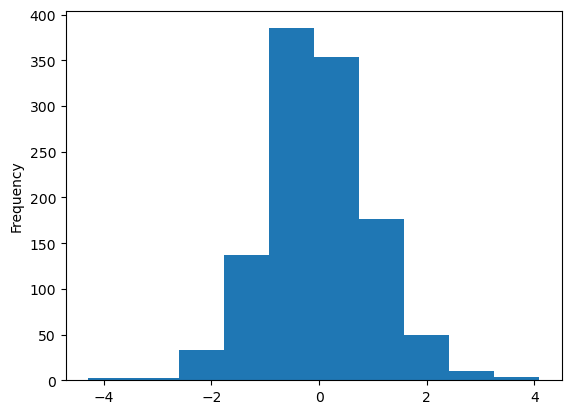

Hearing Difficulty


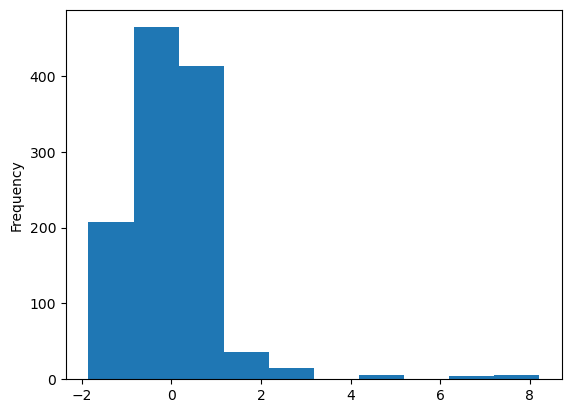

BMI


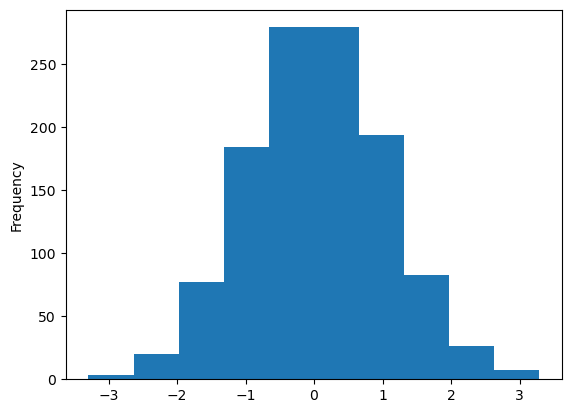

Oily Fish Intake


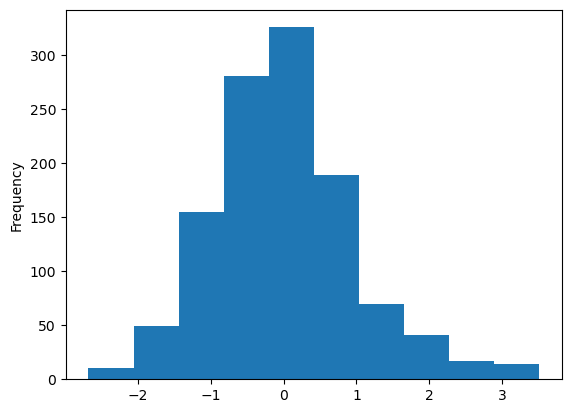

Insomnia


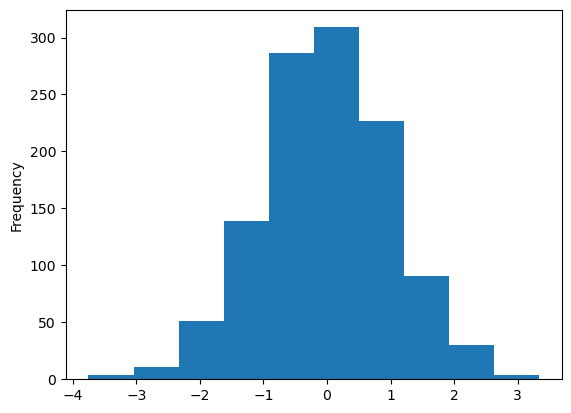

Sleep Duration


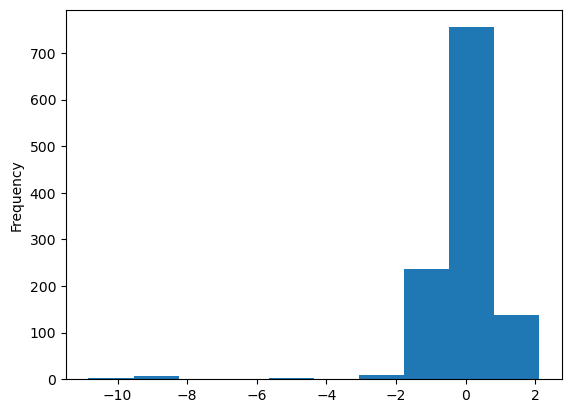

Age completed full time education


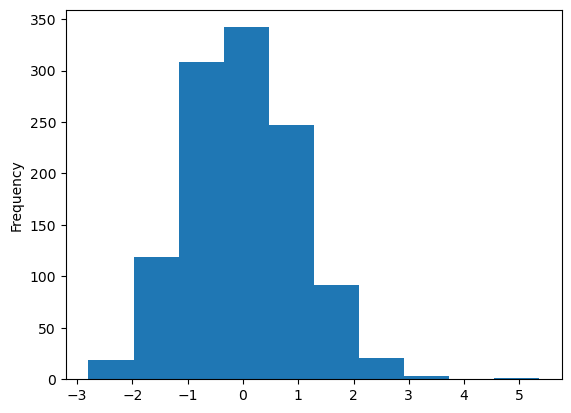

Processed Meat Intake


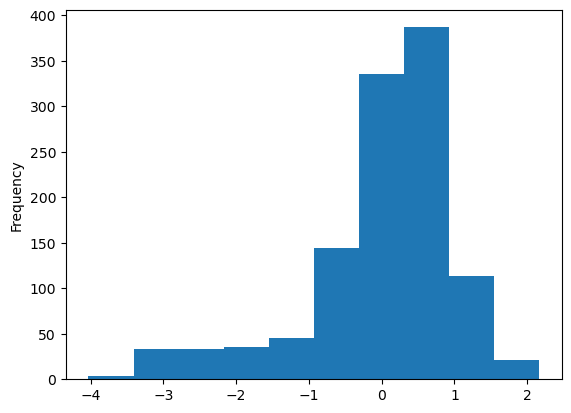

Strenuous Sports


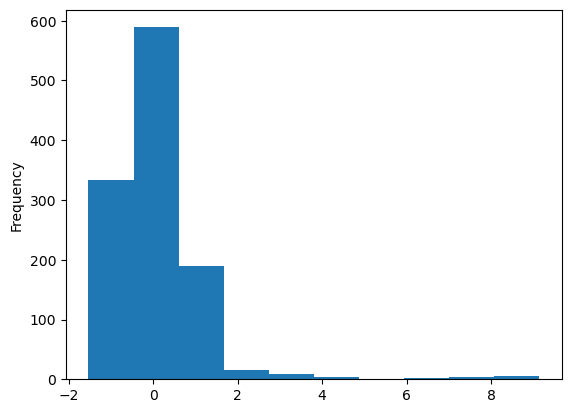

Other Meat Intake


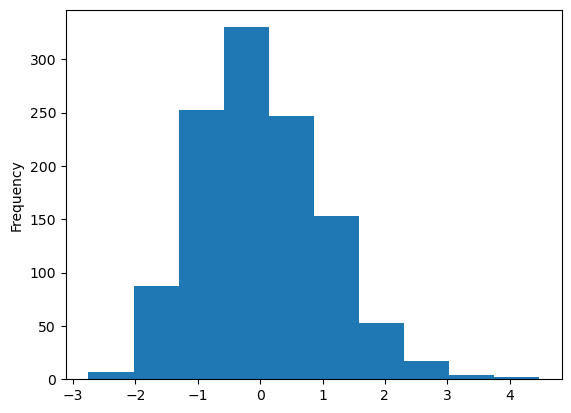

Loneliness


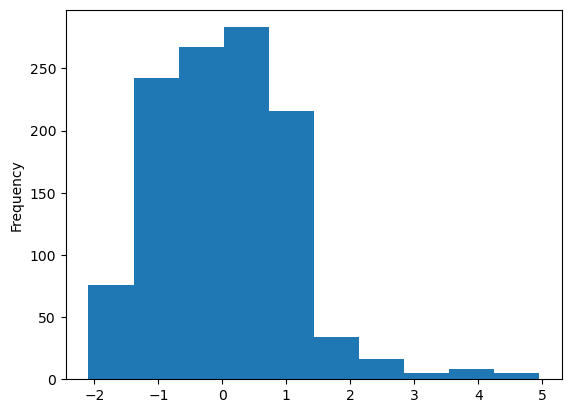

Father's Alzheimer's


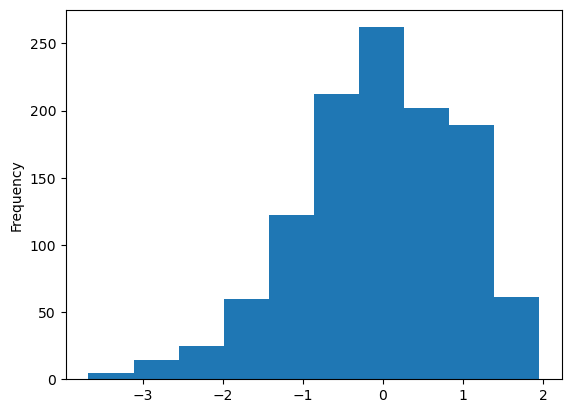

Mother's Alzheimer's


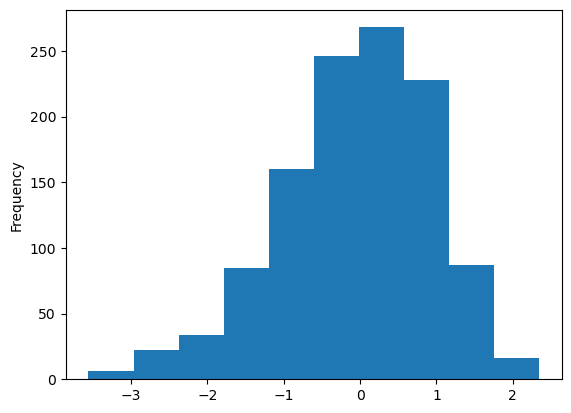

Mood Swings


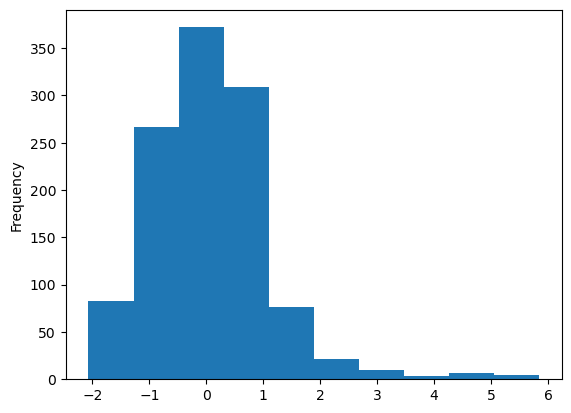

Anxiety/Panic Attacks


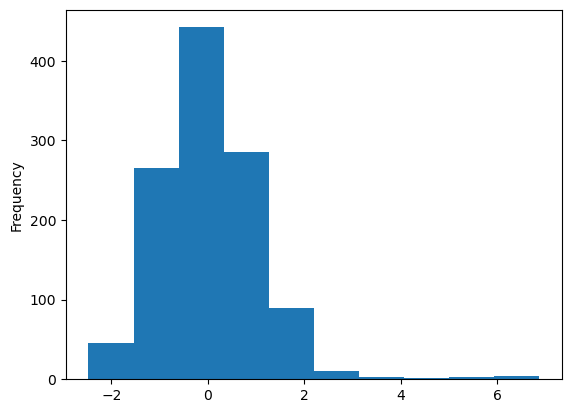

Stroke


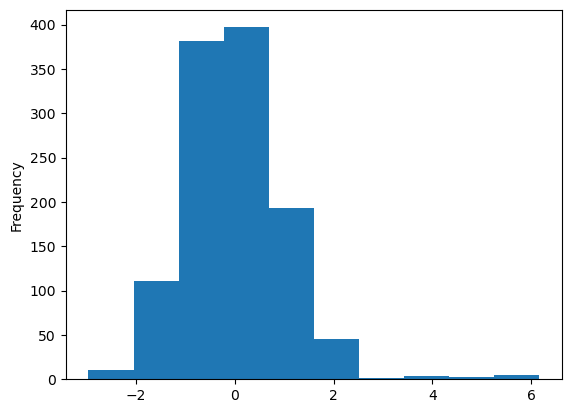

Head Injury


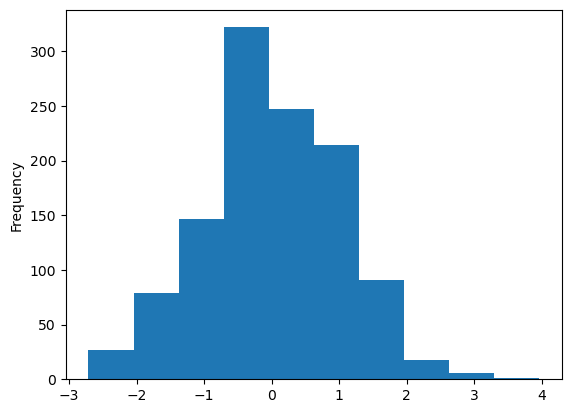

Alcohol Intake Frequency


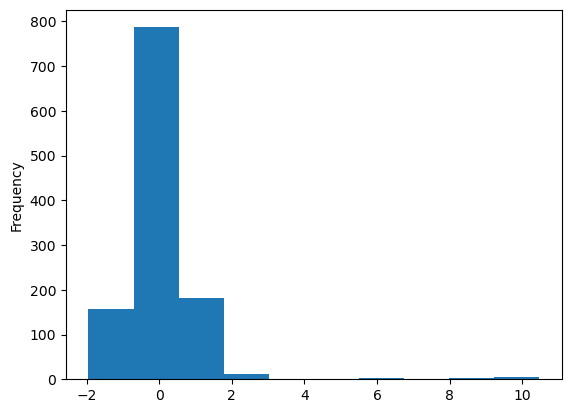

Obesity


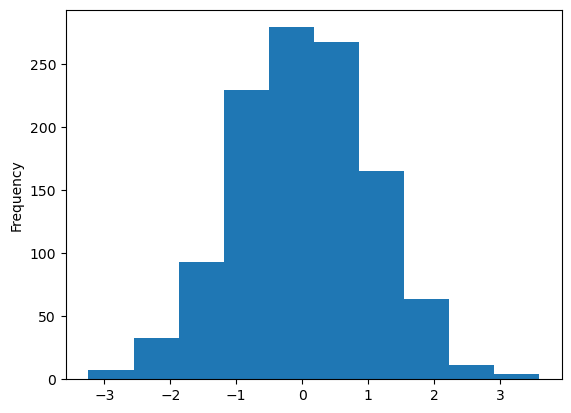

Hypothyroidism


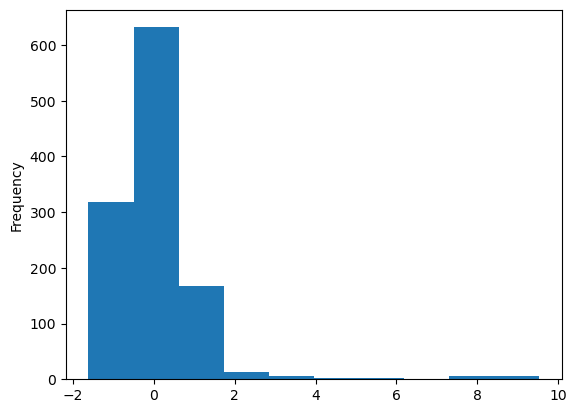

Hyperthyroidism


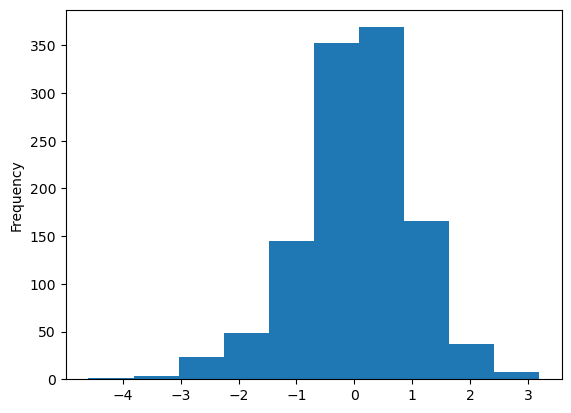

Hypertension 2


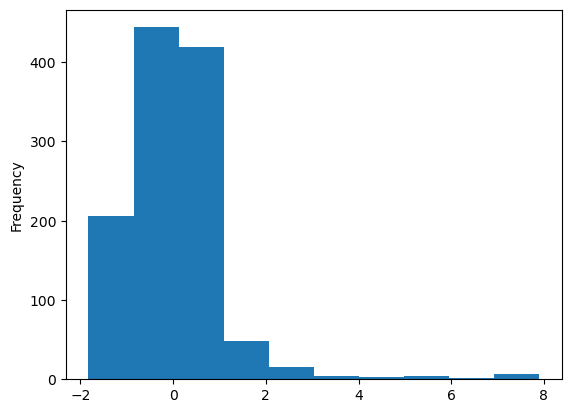

Particulate Matter Air Pollution


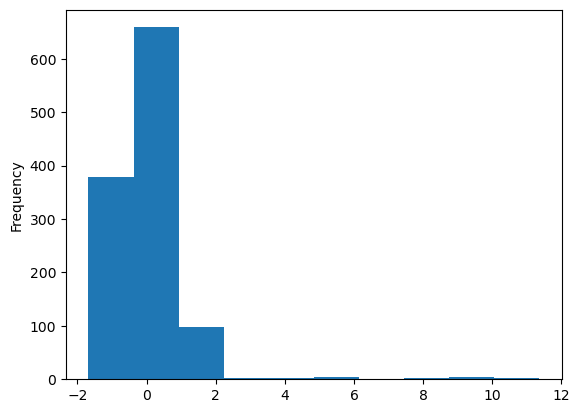

Nitrogen Oxides Air Pollution


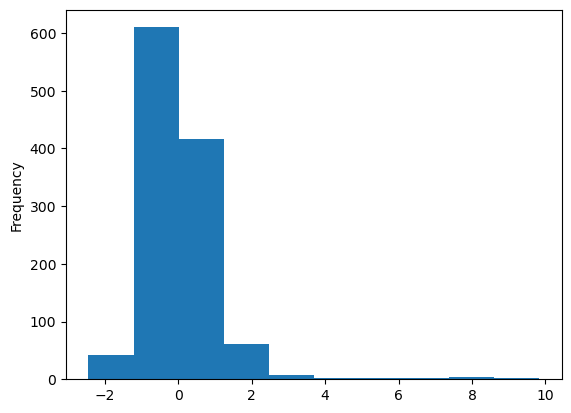

Light Physical Exercise


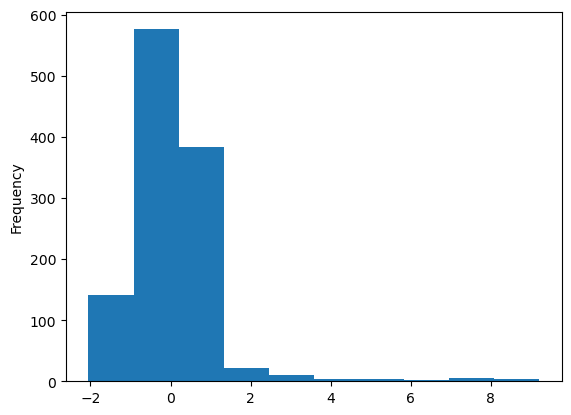

Hypertension 1


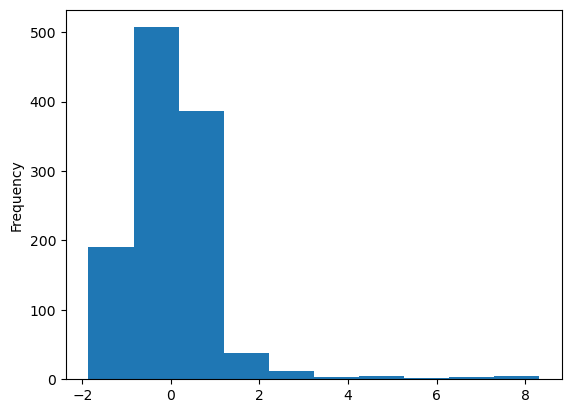

Prospective Memory


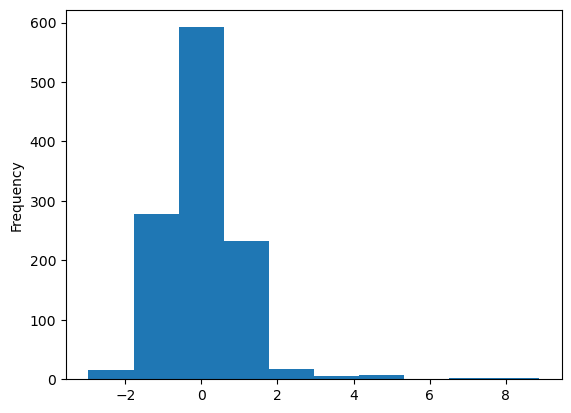

Pub/Social Club


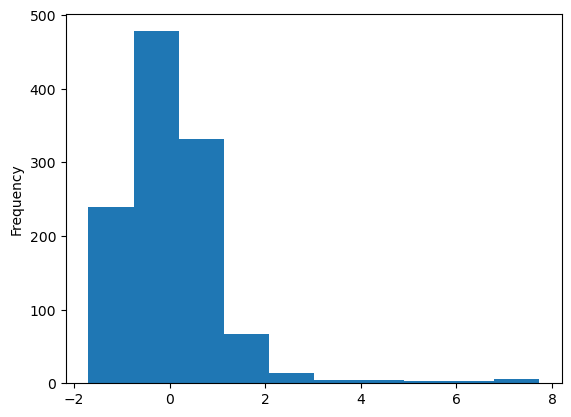

Sports Club/Gym


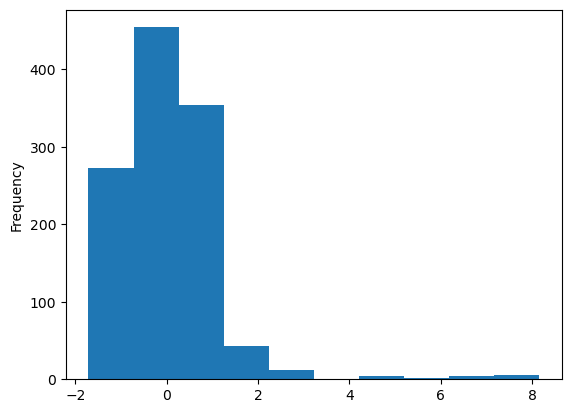

Social Anxiety


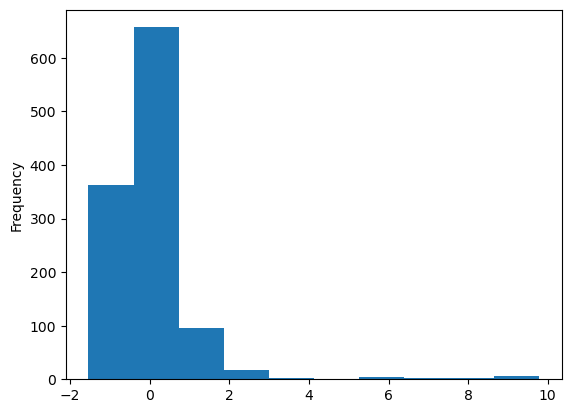

Anxiety Disorder


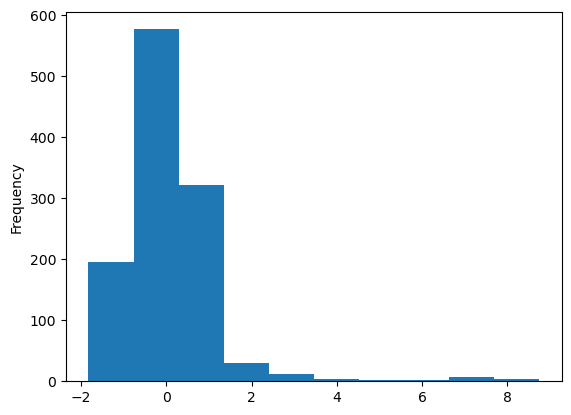

Brain Surgery


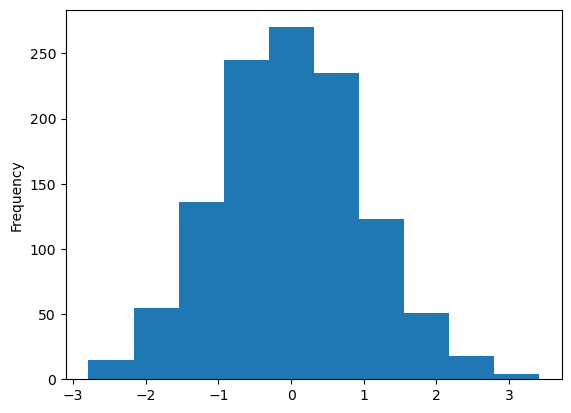

Loss of Interest


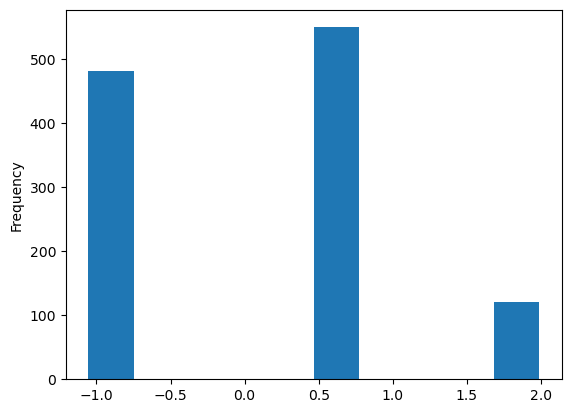

Serious Illness/Injury


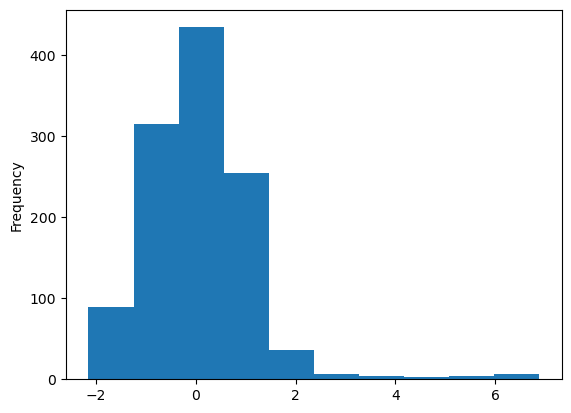

Marital Separation/Divorce


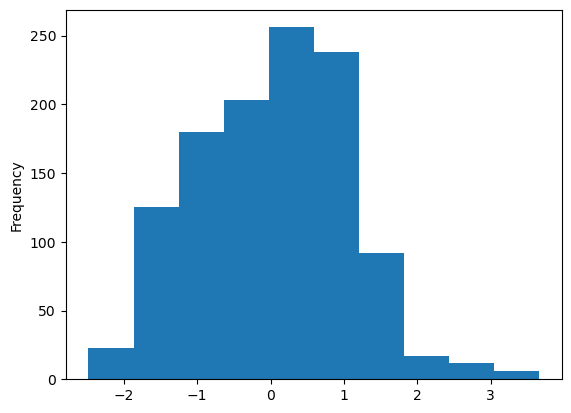

Financial Difficulties


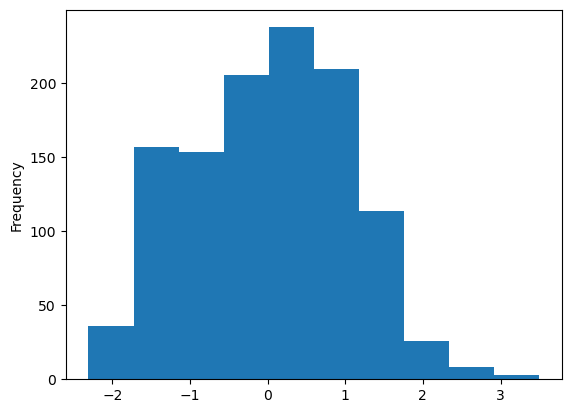

ADHD


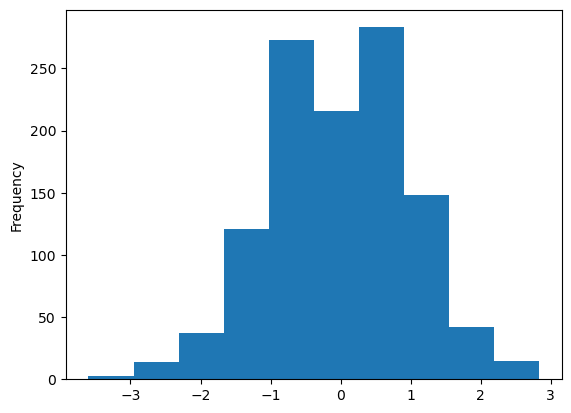

Microalbumin in Urine


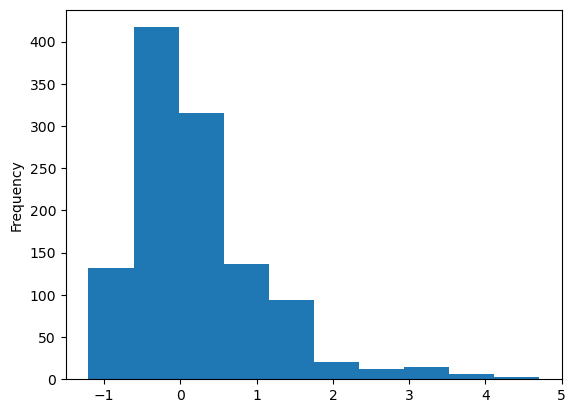

Parkinson's


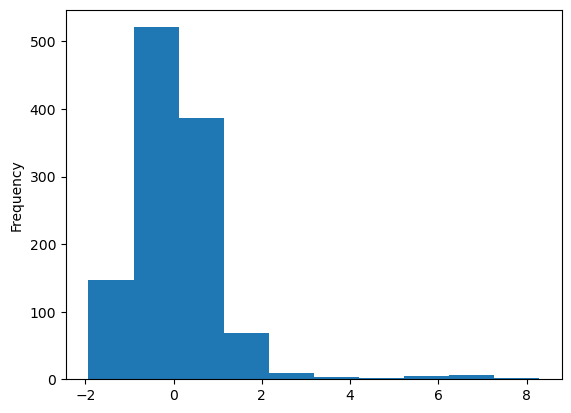

Alzheimer's disease


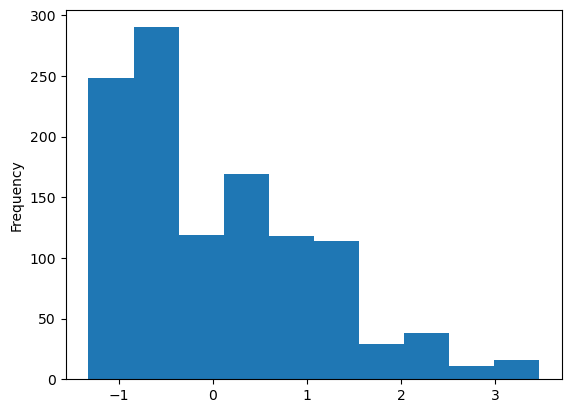

Gender


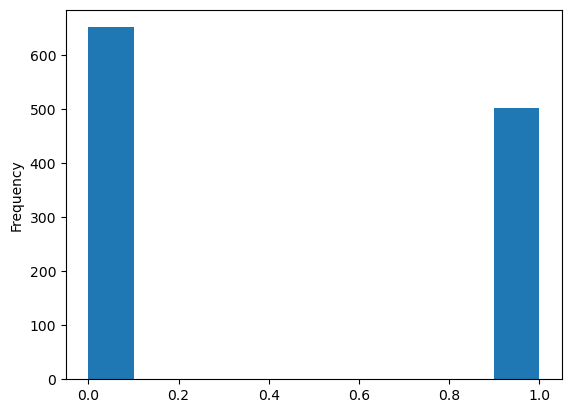

Age


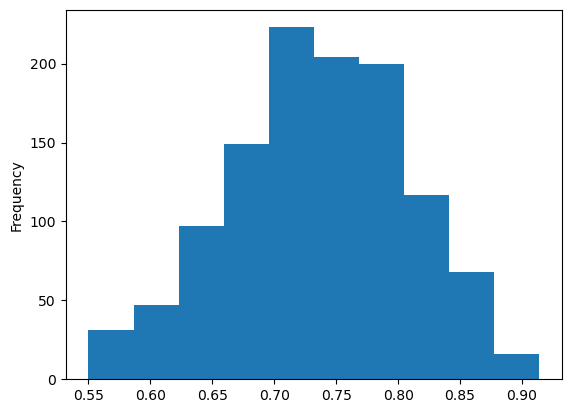

output


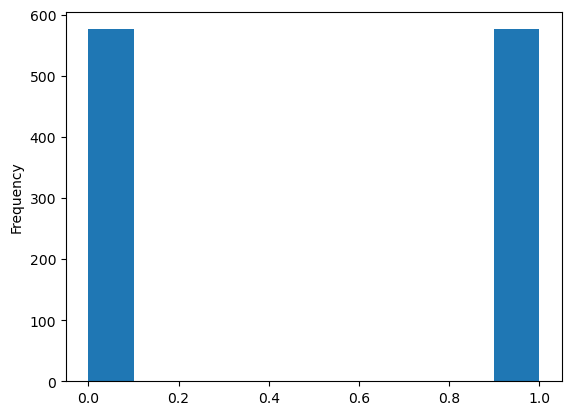

In [115]:
# print(df.head())
column_list = shuffled.columns
for i in column_list:
    print(i)
    shuffled[i].plot(kind="hist")
    plt.show()

**check distribution for positive and negative output with parents' Alzheimer PRS**

In [116]:
# cols_to_check = ["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]
# shuffled_neg = shuffled[shuffled['output'] == 0]


# print('negative PRS values for negative output among ', shuffled_neg.shape[0], " samples")
# print( shuffled_neg[cols_to_check].lt(0).sum() )

# for i in cols_to_check:
#     print(i)
#     shuffled_neg[i].plot(kind="hist")
#     plt.show()

In [117]:
# cols_to_check = ["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]
# shuffled_pos = shuffled[shuffled['output'] == 1]


# print('negative PRS values for positive output among ', shuffled_pos.shape[0], " samples")
# print( shuffled_pos[cols_to_check].lt(0).sum() )

# for i in cols_to_check:
#     print(i)
#     shuffled_pos[i].plot(kind="hist")
#     plt.show()

# Feature Selection
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [118]:
selected_features = []
dict_features = {}

for column in df.columns:
    if column == 'output':
        continue
#     print(column)
    dict_features[column] = 0
print(dict_features)

{'Type 2 Diabetes': 0, 'No recommendation of alcohol consumption': 0, 'Recommendation of alcohol consumption - Yes, Not Last Year': 0, 'Recommendation of alcohol consumption': 0, 'Total Cholesterol': 0, 'HDL Cholesterol': 0, 'LDL Cholesterol': 0, 'Triglycerides': 0, 'Cigarettes per Day': 0, 'Systolic blood pressure': 0, 'Diastolic blood pressure': 0, 'Hearing Difficulty - Yes': 0, 'Depression': 0, 'Non-Oily Fish Intake': 0, 'Hearing Difficulty': 0, 'BMI': 0, 'Oily Fish Intake': 0, 'Insomnia': 0, 'Sleep Duration': 0, 'Age completed full time education': 0, 'Processed Meat Intake': 0, 'Strenuous Sports': 0, 'Other Meat Intake': 0, 'Loneliness': 0, "Father's Alzheimer's": 0, "Mother's Alzheimer's": 0, 'Mood Swings': 0, 'Anxiety/Panic Attacks': 0, 'Stroke': 0, 'Head Injury': 0, 'Alcohol Intake Frequency': 0, 'Obesity': 0, 'Hypothyroidism': 0, 'Hyperthyroidism': 0, 'Hypertension 2': 0, 'Particulate Matter Air Pollution': 0, 'Nitrogen Oxides Air Pollution': 0, 'Light Physical Exercise': 0, '

# Filter methods
Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. These methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods.

**Information Gain**

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

{'Type 2 Diabetes': 0.0, 'No recommendation of alcohol consumption': 0.5235918821568847, 'Recommendation of alcohol consumption - Yes, Not Last Year': 0.28045823993929725, 'Recommendation of alcohol consumption': 0.43138712385500655, 'Total Cholesterol': 0.16143764701422736, 'HDL Cholesterol': 0.0, 'LDL Cholesterol': 0.0, 'Triglycerides': 0.011782605833850891, 'Cigarettes per Day': 0.012202557445571803, 'Systolic blood pressure': 0.0, 'Diastolic blood pressure': 0.0521978549706271, 'Hearing Difficulty - Yes': 0.3194009676170237, 'Depression': 0.015012949508502715, 'Non-Oily Fish Intake': 0.0, 'Hearing Difficulty': 0.40903093703598564, 'BMI': 0.3393355837281886, 'Oily Fish Intake': 0.0, 'Insomnia': 0.0, 'Sleep Duration': 0.03560570734472195, 'Age completed full time education': 0.08375167450059152, 'Processed Meat Intake': 0.16113395861977364, 'Strenuous Sports': 0.5223364334305869, 'Other Meat Intake': 0.0, 'Loneliness': 0.5859685542561879, "Father's Alzheimer's": 1.0, "Mother's Alzhei

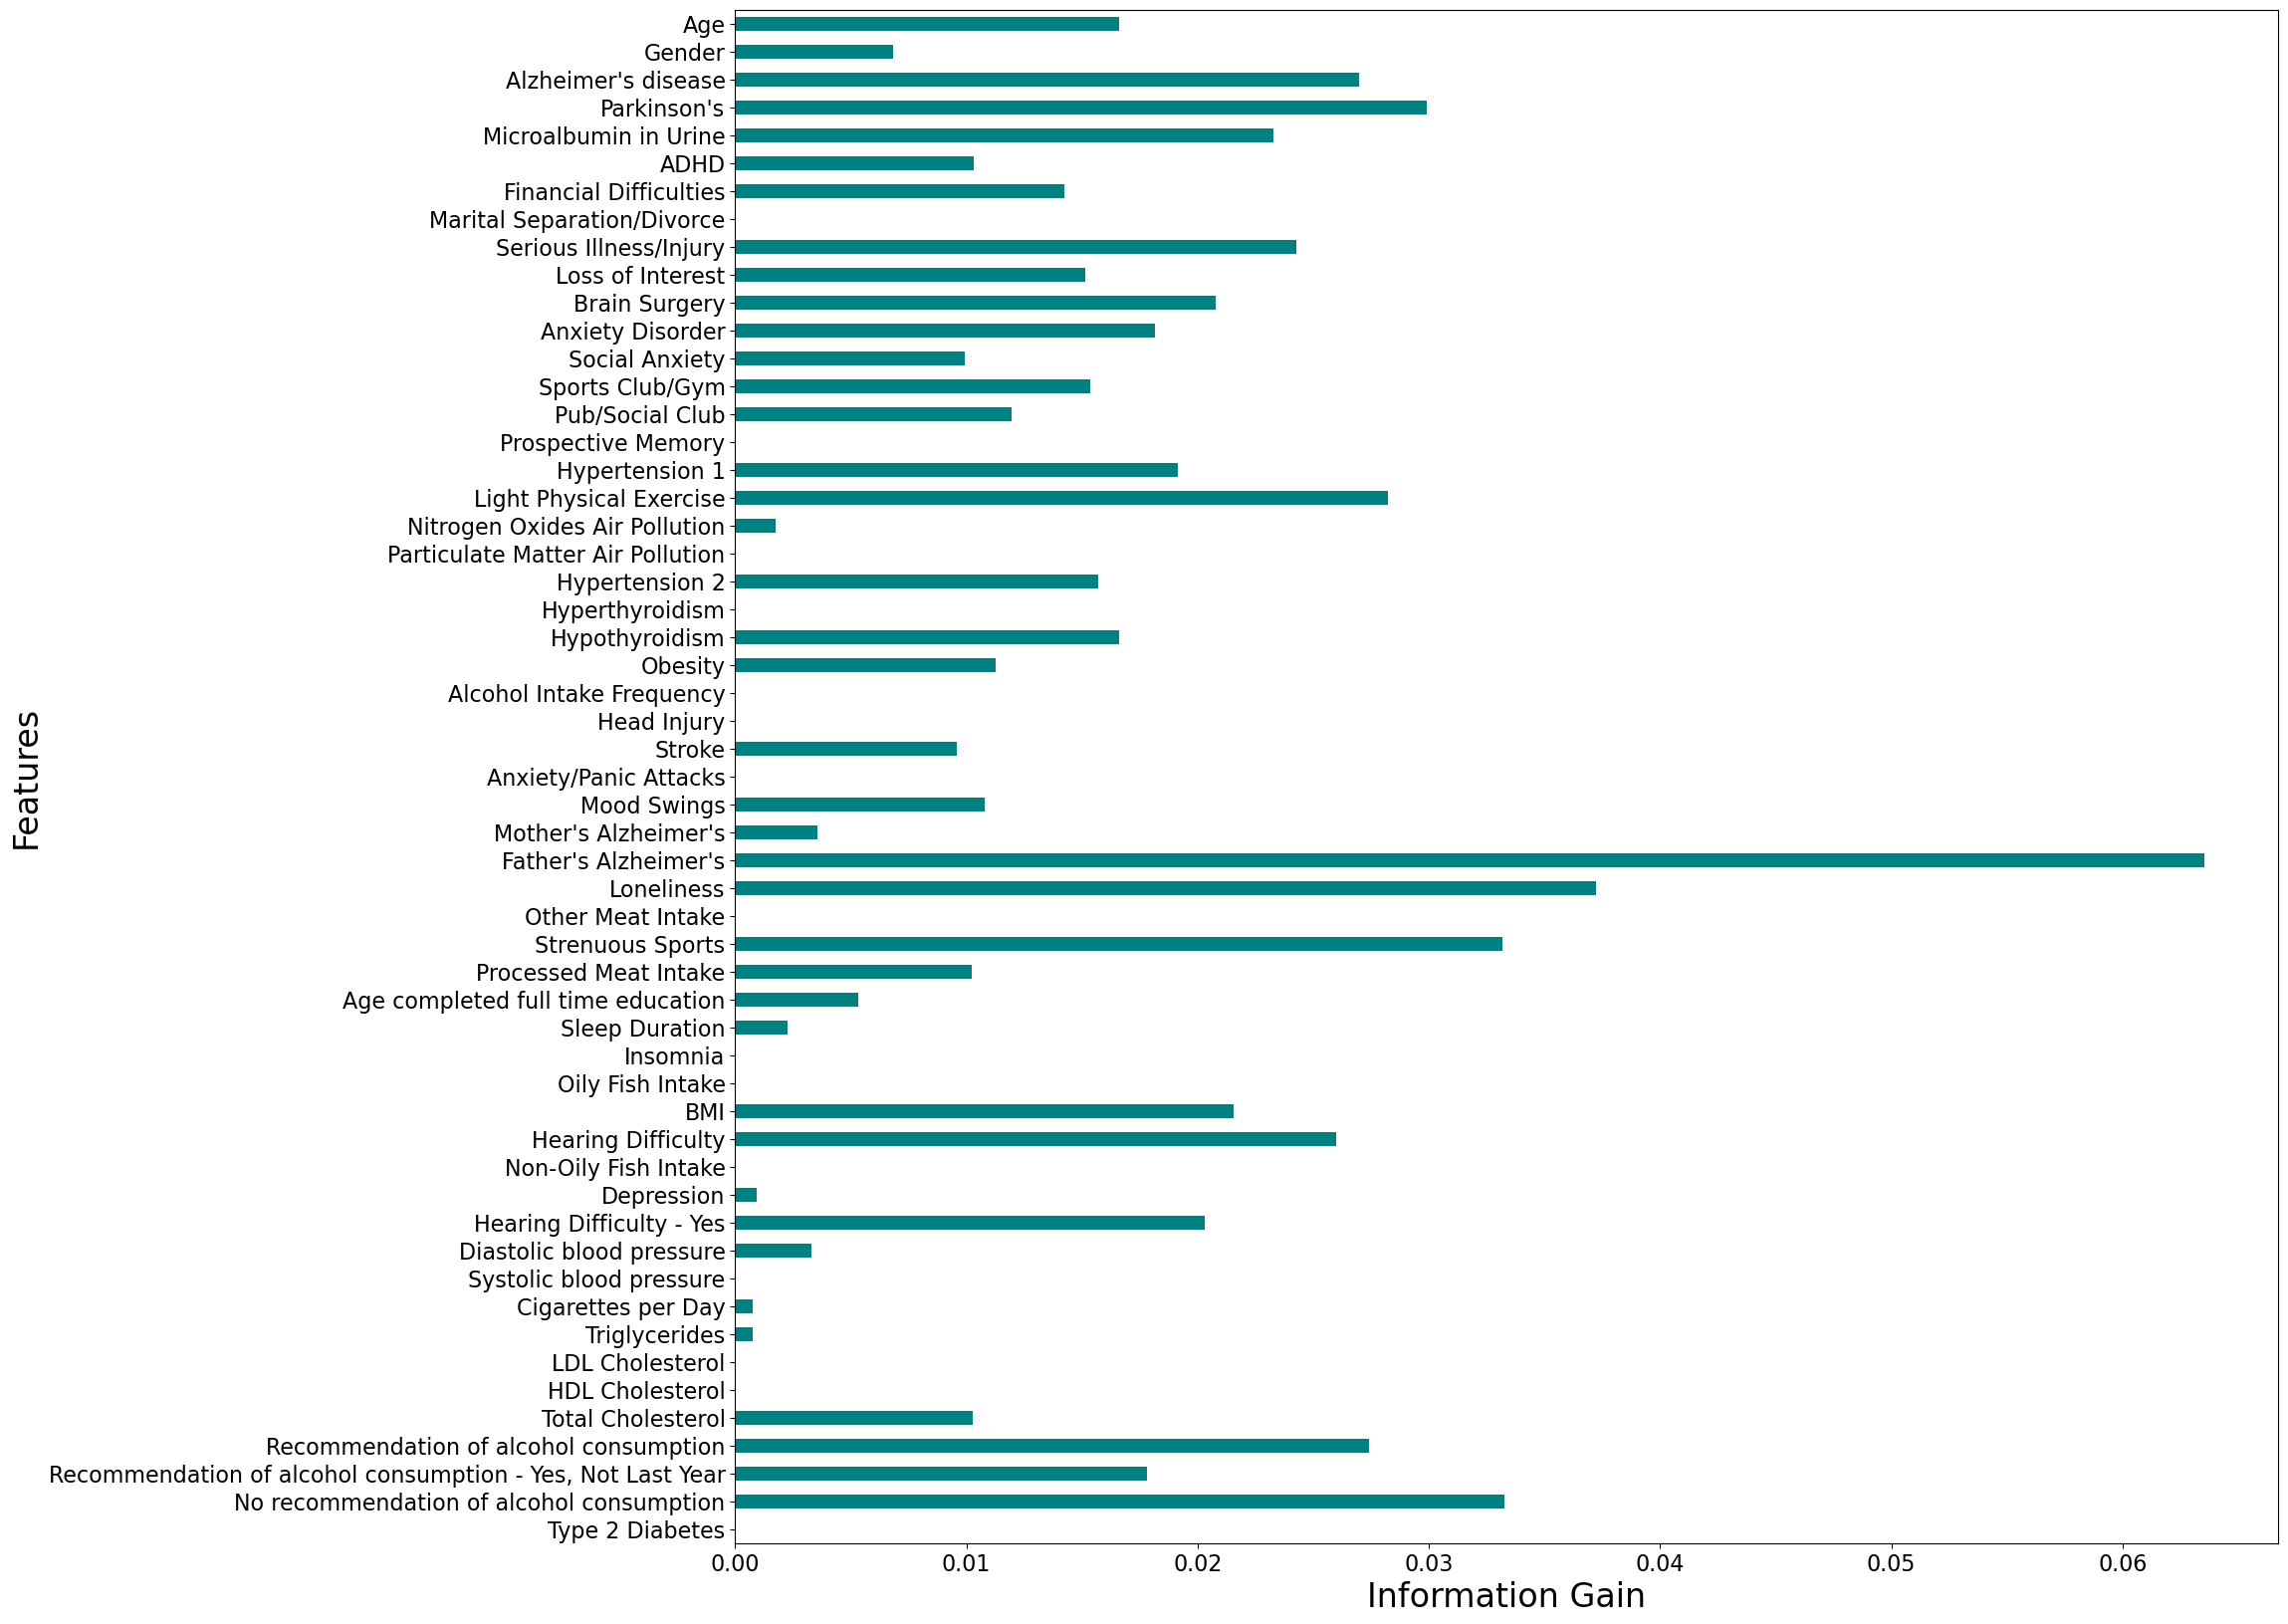

In [119]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=100)


importances = mutual_info_classif(shuffled_X, shuffled_Y)
feat_importances = pd.Series(importances, shuffled.columns[ 0:len(shuffled.columns) - 1 ] )
important_features = []
count = 0
# print(feat_importances)
sorted_feat_importances = feat_importances.sort_values(ascending=True)
min_value = sorted_feat_importances.min()
max_value = sorted_feat_importances.max()
normalized_sorted_feat_importances = (sorted_feat_importances - min_value) / (max_value - min_value)
# print( sorted_feat_importances )
sorted_feature_names = sorted_feat_importances.index
# print(sorted_feature_names)
count = 0
for column in sorted_feature_names:
#     print( normalized_sorted_feat_importances[count])
    dict_features[column] +=  normalized_sorted_feat_importances[count]
    count += 1

# for elem in feat_importances:
#     if elem > 0.05:
#         important_features.append(shuffled.columns[count])
#     count += 1
# print(important_features)

# selected_features += important_features
# print(selected_features)
print(dict_features)
# print(data_dictionary)

# ordered_values = [data_dictionary[key] for key in shuffled_X.columns]
# print(ordered_values)

feat_importances.plot( kind = 'barh', color = 'teal' )
plt.xlabel('Information Gain', fontsize=24)  # Increase the font size of the x-label to 16
plt.ylabel('Features', fontsize=24)  # Increase the font size of the y-label to 16
plt.xticks(fontsize=16)  # Increase the font size of the x-axis tick labels to 12
plt.yticks(fontsize=16)  # Increase the font size of the y-axis tick labels to 12
plt.gca().set_yticklabels(shuffled_X.columns)
plt.show()

**Correlation Coefficient**


<AxesSubplot: >

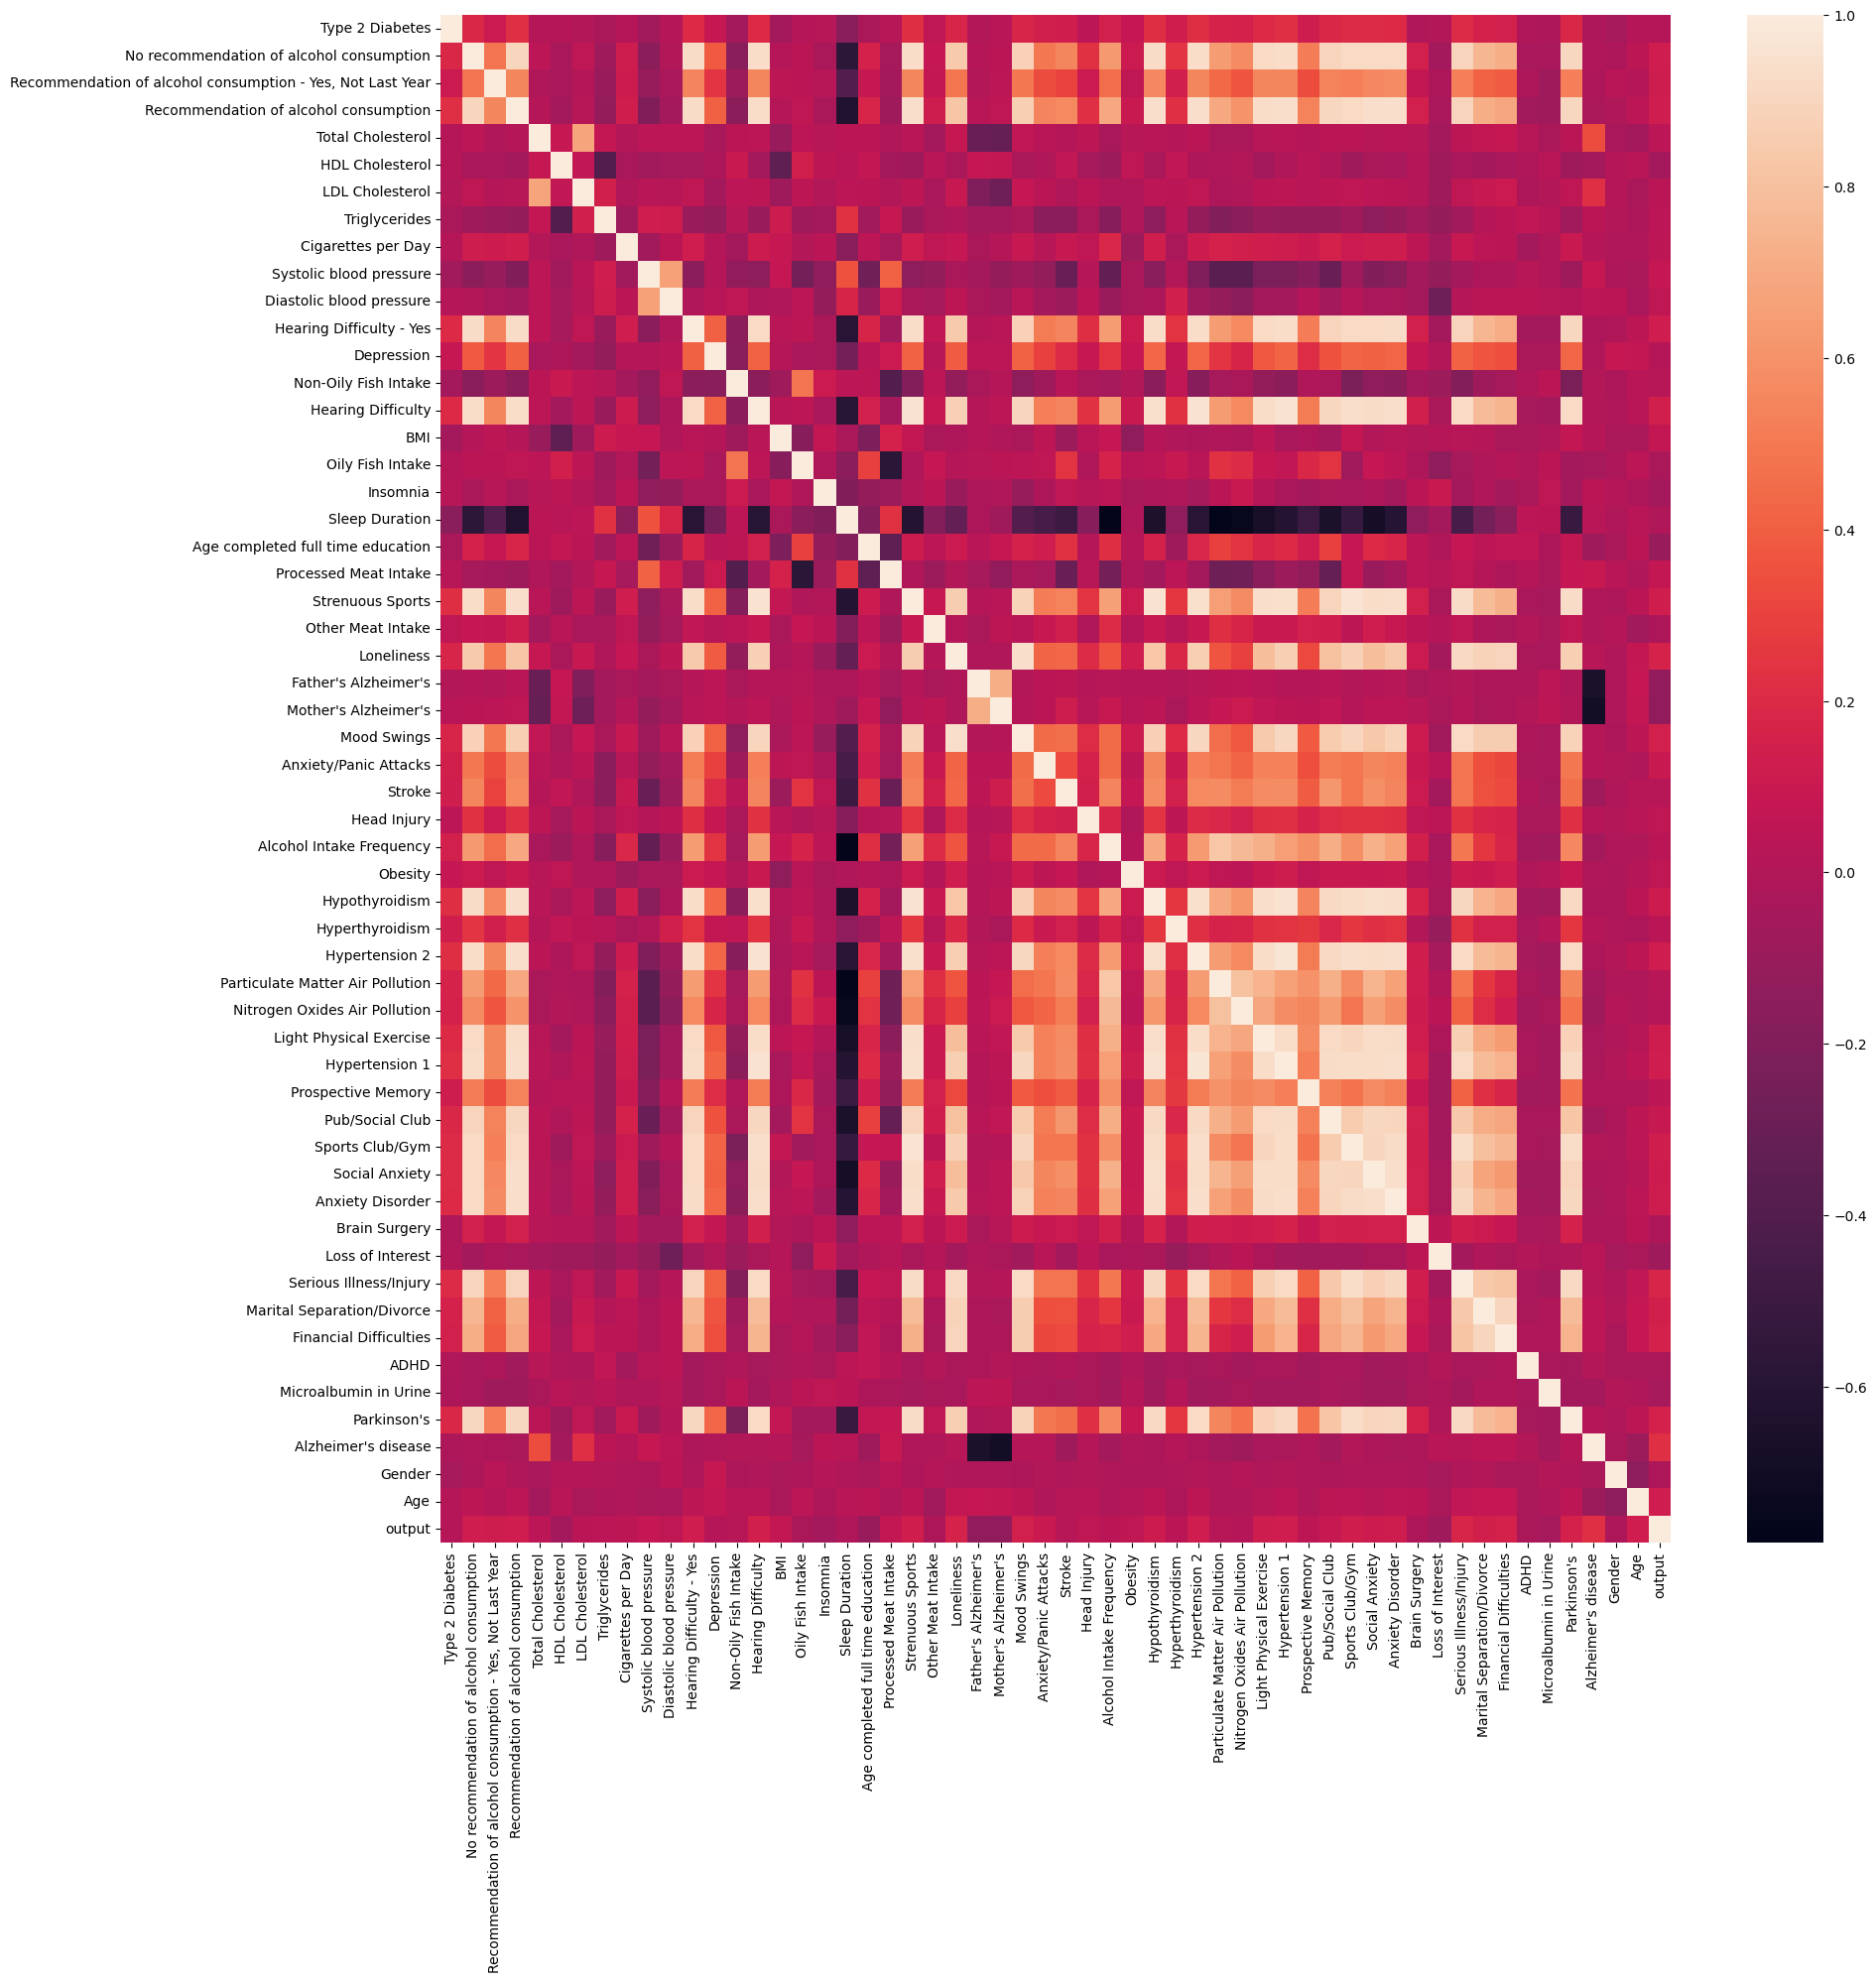

In [120]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
corr = shuffled.corr()
sns.heatmap( corr )

In [121]:
print(corr)

                                                    Type 2 Diabetes  \
Type 2 Diabetes                                            1.000000   
No recommendation of alcohol consumption                   0.188128   
Recommendation of alcohol consumption - Yes, No...         0.108594   
Recommendation of alcohol consumption                      0.222802   
Total Cholesterol                                          0.011184   
HDL Cholesterol                                            0.009422   
LDL Cholesterol                                           -0.000917   
Triglycerides                                             -0.023801   
Cigarettes per Day                                         0.015044   
Systolic blood pressure                                   -0.065421   
Diastolic blood pressure                                   0.007360   
Hearing Difficulty - Yes                                   0.198797   
Depression                                                 0.085024   
Non-Oi

**Still Alzheimer of parents show negative correlation:**
    1. Lack of Diagnosis for parents.
    2. Less patients overall earlier.
    3. Lack of such patients in this dataset

In [122]:
print(corr.iloc[0][0])
features_selected = []
column_len = len( shuffled.columns )
output_idx = column_len - 1

# Get the correlation column with the output variable
correlation_column = corr.iloc[:, output_idx]

# Sort the correlation column and get the corresponding feature indices
sorted_feature_indices = correlation_column.argsort()

# Get the corresponding feature names using the sorted indices
sorted_feature_names = shuffled.columns[sorted_feature_indices]
print(sorted_feature_names)

count = 1
min_value = correlation_column.min()
max_value = correlation_column.max()

for column in sorted_feature_names:
    if column == 'output':
        continue
    # Calculate the normalized correlation value
#     print(column, correlation_column.loc[column])
    normalized_correlation = (correlation_column.loc[column] - min_value) / (max_value - min_value)
    
    print(f"{column}: {normalized_correlation}")  # Print the feature and its normalized correlation
    dict_features[column] += normalized_correlation      
    
# for column in sorted_feature_names:
#     if column == 'output':
#         continue
#     print(column)
#     dict_features[column] += count
#     count += 1

print( dict_features )
    

# for i in range( column_len ): 
#     if (corr.iloc[i][output_idx] > 0.1 ) and i != output_idx :
#         features_selected.append(shuffled.columns[i])
# print(features_selected)

# selected_features += features_selected

1.0
Index(['Father's Alzheimer's', 'Mother's Alzheimer's',
       'Age completed full time education', 'Loss of Interest', 'Insomnia',
       'HDL Cholesterol', 'Microalbumin in Urine', 'Oily Fish Intake', 'ADHD',
       'Gender', 'Brain Surgery', 'Other Meat Intake', 'Sleep Duration',
       'Type 2 Diabetes', 'Depression', 'Nitrogen Oxides Air Pollution',
       'Stroke', 'Non-Oily Fish Intake', 'Particulate Matter Air Pollution',
       'Hyperthyroidism', 'Alcohol Intake Frequency', 'LDL Cholesterol',
       'Total Cholesterol', 'Triglycerides', 'Prospective Memory',
       'Cigarettes per Day', 'Head Injury', 'Obesity',
       'Diastolic blood pressure', 'Processed Meat Intake', 'BMI',
       'Systolic blood pressure', 'Pub/Social Club', 'Anxiety/Panic Attacks',
       'Social Anxiety', 'Hypothyroidism', 'Light Physical Exercise',
       'Recommendation of alcohol consumption - Yes, Not Last Year',
       'Anxiety Disorder', 'Hearing Difficulty - Yes', 'Hypertension 1',
       'Rec

**Variance Threshold**

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.

In [123]:
from sklearn.feature_selection import VarianceThreshold

# remove features with variance less than 0.1
v_threshold = VarianceThreshold( threshold = 0.1 )
v_threshold.fit(shuffled_X)
print( v_threshold.get_support() )
rejected_col = [x for x, y in zip(shuffled_X.columns, v_threshold.get_support() ) if y == False]
print(rejected_col)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
['Age']


Makes sense as most of the age is very high for AD patients. No need to reject the "age" column

**Mean Absolute Difference (MAD)**

The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant.’ This means that higher the MAD, higher the discriminatory power.

Text(0.5, 1.0, 'Mean Absolute Difference of Features')

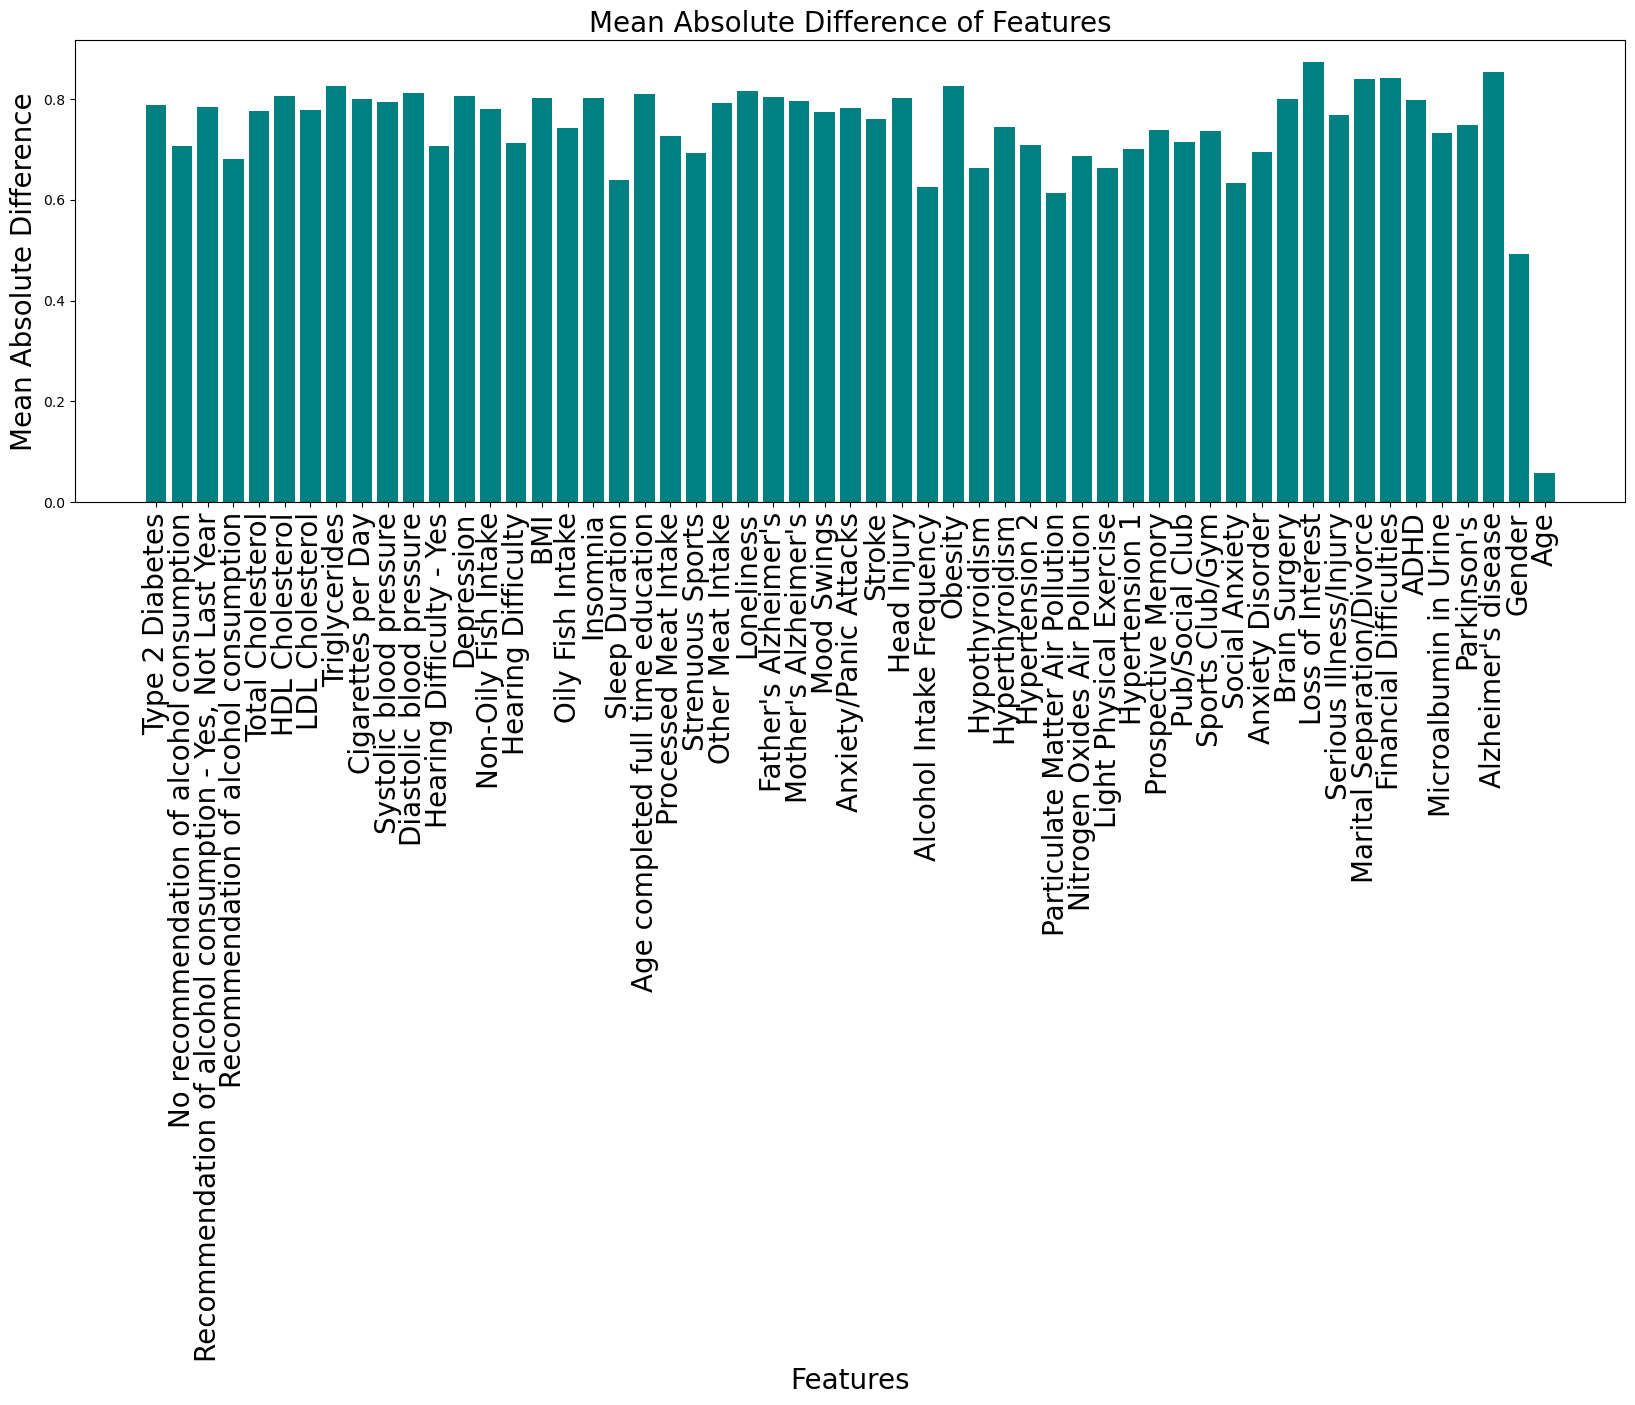

In [124]:
mean_abs_diff = np.sum( np.abs( shuffled_X - np.mean(shuffled_X, axis = 0 ) ), axis = 0 ) / shuffled_X.shape[0]

plt.figure(figsize=(20, 6))  # Adjust the figure size as per your preference

plt.bar( np.arange( shuffled_X.shape[1] ), mean_abs_diff, color = 'teal' )
plt.xticks(np.arange(shuffled_X.shape[1]), shuffled_X.columns, rotation = 90, fontsize=20)  # Set the tick labels and font size
plt.xlabel('Features', fontsize=20)  # Set the x-axis label and font size
plt.ylabel('Mean Absolute Difference', fontsize=20)  # Set the y-axis label and font size
plt.title('Mean Absolute Difference of Features', fontsize=20)  # 

# Wrapper Methods

Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

**Forward Feature Selection**

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved.

In [125]:
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(shuffled_X, shuffled_Y)

ffs = SequentialFeatureSelector( rfc, k_features = 'best', forward = True, n_jobs = -1 )
ffs.fit(shuffled_X, shuffled_Y)
features = list( ffs.k_feature_names_ )
print(features)
print( len( features ) )

for column in features:
    dict_features[column] += 1 

# selected_features += features
# print(selected_features)

['No recommendation of alcohol consumption', "Father's Alzheimer's", 'Alcohol Intake Frequency', 'Hypothyroidism', 'Particulate Matter Air Pollution', 'Brain Surgery', 'Loss of Interest', "Alzheimer's disease", 'Age']
9


In [126]:
print(dict_features)


{'Type 2 Diabetes': 0.12225684054080724, 'No recommendation of alcohol consumption': 1.7536629384445148, 'Recommendation of alcohol consumption - Yes, Not Last Year': 0.5009362638934808, 'Recommendation of alcohol consumption': 0.6585797822793633, 'Total Cholesterol': 0.3149381884572991, 'HDL Cholesterol': 0.06324314150908468, 'LDL Cholesterol': 0.1504405566673208, 'Triglycerides': 0.16983561248298112, 'Cigarettes per Day': 0.17368740009332878, 'Systolic blood pressure': 0.18834315867367296, 'Diastolic blood pressure': 0.21753695994554012, 'Hearing Difficulty - Yes': 0.5453169552886076, 'Depression': 0.1402580298927852, 'Non-Oily Fish Intake': 0.13744234746435097, 'Hearing Difficulty': 0.6495849584373502, 'BMI': 0.5207286283432293, 'Oily Fish Intake': 0.08654441568716228, 'Insomnia': 0.06284539606373701, 'Sleep Duration': 0.14206855065707794, 'Age completed full time education': 0.11055396659783116, 'Processed Meat Intake': 0.33917513995885723, 'Strenuous Sports': 0.7571082570130908, '

**Backward Feature Elimination**

This method works exactly opposite to the Forward Feature Selection method. Here, we start with all the features available and build a model. Next, we remove the variable from the model which gives the best evaluation measure value. This process is continued until the preset criterion is achieved.

In [127]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

lr = LogisticRegression( class_weight = 'balanced', solver = 'lbfgs', random_state = 42, n_jobs = -1, max_iter = 500 )
lr.fit(shuffled_X, shuffled_Y)

bfs = SequentialFeatureSelector( lr, k_features = 'best', forward = False, n_jobs = -1 )
bfs.fit(shuffled_X, shuffled_Y)
features = list( bfs.k_feature_names_ )
print(features)
print( len( features ) )

for column in features:
    dict_features[column] += 1 
    
# selected_features += features
# print(selected_features)

['Recommendation of alcohol consumption - Yes, Not Last Year', 'Total Cholesterol', 'Cigarettes per Day', 'Systolic blood pressure', 'Hearing Difficulty - Yes', 'Depression', 'Non-Oily Fish Intake', 'BMI', 'Age completed full time education', 'Processed Meat Intake', 'Loneliness', 'Obesity', 'Hyperthyroidism', 'Sports Club/Gym', 'Brain Surgery', 'Serious Illness/Injury', 'Marital Separation/Divorce', 'Financial Difficulties', 'ADHD', "Parkinson's", "Alzheimer's disease", 'Gender', 'Age']
23


**Exhaustive Feature Selection**

This is the most robust feature selection method covered so far. This is a brute-force evaluation of each feature subset. This means that it tries every possible combination of the variables and returns the best performing subset.

In [128]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector

# from sklearn.ensemble import RandomForestClassifier

# efs = ExhaustiveFeatureSelector( RandomForestClassifier(), min_features = 8, max_features = 10, scoring = 'roc_auc', cv = 2)
# efs.fit(shuffled_X, shuffled_Y)

# selected_features = shuffled_X.columns[list(efs.best_idx_)]
# print(selected_features)

# print(efs.best_score_)

**Recursive Feature Elimination**

‘Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.’

In [129]:
from sklearn.feature_selection import RFE
# here lr denotes the logistic regression model trained on backward elimination
rfe = RFE(lr, n_features_to_select = 1 )
rfe.fit(shuffled_X, shuffled_Y)
selected_col = [ x for x, y in zip(shuffled_X.columns, rfe.support_ )  if y == True ]
print(selected_col)
print( len (selected_col ) )
print(rfe.ranking_)

min_rank = rfe.ranking_.min()
max_rank = rfe.ranking_.max()
normalized_rfe_rankings = 1 - ((rfe.ranking_ - min_rank) / (max_rank - min_rank))

# selected_features += selected_col 
print("Normalized RFE Rankings:", normalized_rfe_rankings)

# Create a dictionary mapping column names to normalized rankings
column_rank_dict = {column: normalized_rank for column, normalized_rank in zip(shuffled_X.columns, normalized_rfe_rankings)}

# Sort the dictionary by normalized ranking
sorted_column_rank = dict(sorted(column_rank_dict.items(), key=lambda item: item[1]))

print("Sorted Column Rankings:")
for column, normalized_rank in sorted_column_rank.items():
    print(f"{column}: {normalized_rank}")
    dict_features[column] += normalized_rank

# print(selected_features)

['Age']
1
[36 33 10 25 23 31 44 48 21 20 42 28 14 13 50 18 55 11 46  8 30 38 40 27
 43 26 51 15 54 41 47 22  4 39 19 29 53  7 45 49 12  5 34 24 37  9  3 16
 17 35 32  6  2 52  1]
Normalized RFE Rankings: [0.35185185 0.40740741 0.83333333 0.55555556 0.59259259 0.44444444
 0.2037037  0.12962963 0.62962963 0.64814815 0.24074074 0.5
 0.75925926 0.77777778 0.09259259 0.68518519 0.         0.81481481
 0.16666667 0.87037037 0.46296296 0.31481481 0.27777778 0.51851852
 0.22222222 0.53703704 0.07407407 0.74074074 0.01851852 0.25925926
 0.14814815 0.61111111 0.94444444 0.2962963  0.66666667 0.48148148
 0.03703704 0.88888889 0.18518519 0.11111111 0.7962963  0.92592593
 0.38888889 0.57407407 0.33333333 0.85185185 0.96296296 0.72222222
 0.7037037  0.37037037 0.42592593 0.90740741 0.98148148 0.05555556
 1.        ]
Sorted Column Rankings:
Oily Fish Intake: 0.0
Stroke: 0.01851851851851849
Nitrogen Oxides Air Pollution: 0.03703703703703709
Gender: 0.05555555555555558
Mood Swings: 0.07407407407407407
H

# Embedded Methods

These methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

**LASSO Regularization (L1)**

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e. to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

logistic = LogisticRegression( C = 1, penalty = "l1", solver = 'liblinear', random_state = 42 ).fit(shuffled_X, shuffled_Y )

model = SelectFromModel(logistic, prefit = True )

X_new = model.transform(shuffled_X)

selected_feat = shuffled_X.columns[(model.get_support())]
# print(selected_feat)
print( len( selected_feat ) )
# selected_columns = shuffled_X.columns[X_new.var() != 0 ]
# print(selected_columns)
# print( len(selected_columns[0] ) )
# print(type(selected_feat))
# print( selected_feat.tolist() )
selected_features += selected_feat.tolist()

for column in selected_feat:
    print(column)
    dict_features[column] += 1

# print(selected_features)

47
Type 2 Diabetes
Recommendation of alcohol consumption - Yes, Not Last Year
Recommendation of alcohol consumption
Total Cholesterol
HDL Cholesterol
LDL Cholesterol
Triglycerides
Cigarettes per Day
Systolic blood pressure
Diastolic blood pressure
Hearing Difficulty - Yes
Depression
Non-Oily Fish Intake
Hearing Difficulty
BMI
Oily Fish Intake
Insomnia
Sleep Duration
Age completed full time education
Processed Meat Intake
Other Meat Intake
Loneliness
Father's Alzheimer's
Mother's Alzheimer's
Anxiety/Panic Attacks
Stroke
Head Injury
Obesity
Hypothyroidism
Hyperthyroidism
Hypertension 2
Particulate Matter Air Pollution
Light Physical Exercise
Prospective Memory
Pub/Social Club
Sports Club/Gym
Anxiety Disorder
Brain Surgery
Loss of Interest
Serious Illness/Injury
Marital Separation/Divorce
Financial Difficulties
ADHD
Microalbumin in Urine
Parkinson's
Alzheimer's disease
Age


**Random Forest Importance**

Random Forests is a kind of a Bagging Algorithm that aggregates a specified number of decision trees. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features.

[0.01630422 0.01976128 0.01889508 0.01649871 0.01562516 0.01801948
 0.01528765 0.01690283 0.01753193 0.02064829 0.01828177 0.01637039
 0.01843153 0.01756517 0.01968028 0.01921221 0.01554946 0.0192116
 0.01677068 0.02091334 0.01812396 0.02612085 0.01770756 0.01722007
 0.02512688 0.0216132  0.0178991  0.0189839  0.01672087 0.01869089
 0.0166068  0.01720278 0.01931131 0.0159402  0.01469319 0.01747966
 0.0173779  0.02175215 0.01440487 0.01574409 0.01480686 0.01793454
 0.01664269 0.01496913 0.01764678 0.00411769 0.02571041 0.01389557
 0.01980468 0.0174651  0.00801492 0.01961973 0.04899903 0.00217051
 0.0320211 ]


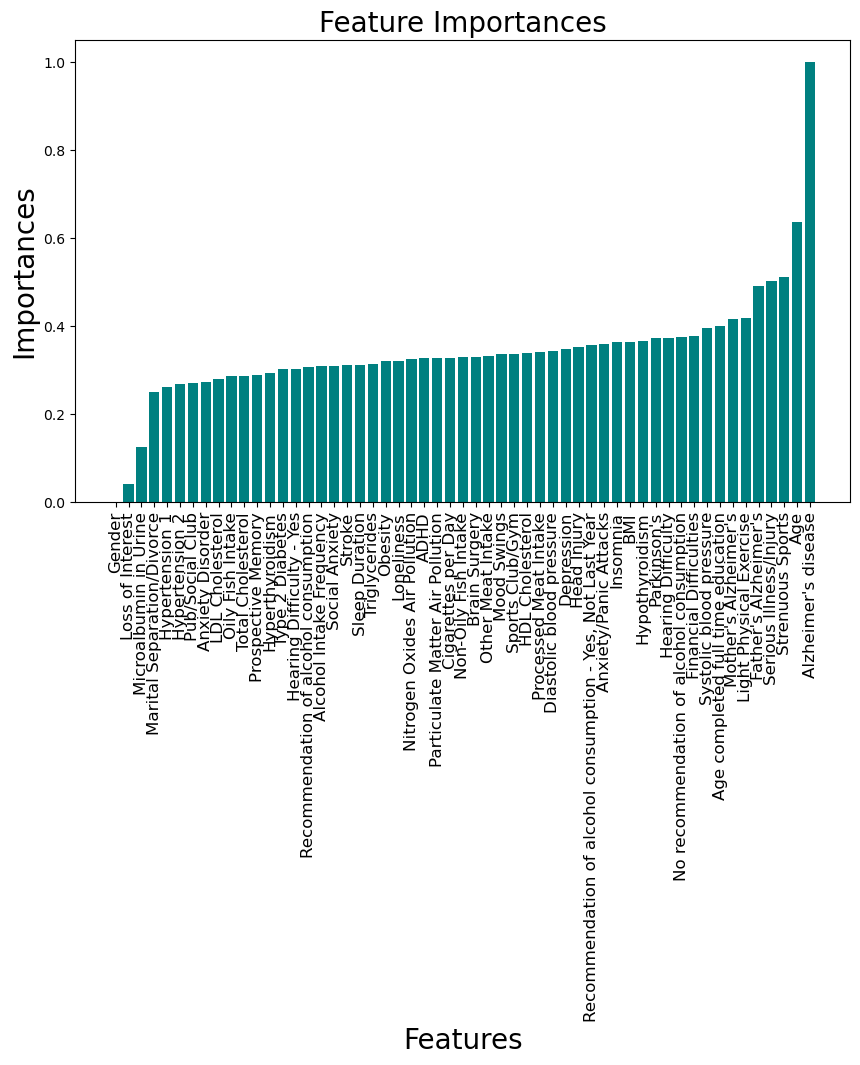

In [131]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( n_estimators = 340, random_state = 42 )

model.fit(shuffled_X, shuffled_Y)

importances = model.feature_importances_
print(importances)

# Normalize the importances
min_importance = min(importances)
max_importance = max(importances)
normalized_importances = (importances - min_importance) / (max_importance - min_importance)


final_df = pd.DataFrame({"Features" : pd.DataFrame(shuffled_X).columns, "Importances" : normalized_importances } )
final_df.set_index('Importances')


final_df = final_df.sort_values('Importances')
# final_df.plot.bar(color = 'teal')
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.bar(final_df['Features'], final_df['Importances'], color='teal')
plt.xticks(rotation=90, fontsize=12)  # Increase font size and rotate X-axis labels
plt.xlabel('Features', fontsize=20)  # Add X-axis label
plt.ylabel('Importances', fontsize=20)  # Add Y-axis label
plt.title('Feature Importances', fontsize=20)  # Add plot title
plt.show()

In [132]:
# print(type( final_df ) )
# print(final_df.columns)
# print(final_df['Features'].iloc[-10:])
# important_cols = []
# important_cols = final_df['Features'].iloc[-10:].values.tolist()
# print(important_cols)

# selected_features += important_cols
for index, row in final_df.iterrows():
#     print(row)
    importance = row['Importances']
    column = row['Features']
#     print(type(column), type(importance) )
    dict_features[column] += importance

# Select features based on all methods

https://www.digitalocean.com/community/tutorials/python-counter-python-collections-counter

In [133]:
print( dict_features.items())
sorted_dict = {k: v for k, v in sorted(dict_features.items(), key=lambda item: item[1], reverse=True)}
print(sorted_dict)

dict_items([('Type 2 Diabetes', 1.77592700805092), ('No recommendation of alcohol consumption', 2.5367124409003567), ('Recommendation of alcohol consumption - Yes, Not Last Year', 3.6914144117483354), ('Recommendation of alcohol consumption', 2.5201068876654222), ('Total Cholesterol', 3.1948482189339753), ('HDL Cholesterol', 1.8461345503129643), ('LDL Cholesterol', 1.634254343694507), ('Triglycerides', 1.614066733168523), ('Cigarettes per Day', 3.1313526100795563), ('Systolic blood pressure', 3.2310750928944456), ('Diastolic blood pressure', 1.8023256984444298), ('Hearing Difficulty - Yes', 3.3485483361760098), ('Depression', 3.2467633187508804), ('Non-Oily Fish Intake', 3.2439654013241777), ('Hearing Difficulty', 2.1160900405847385), ('BMI', 3.5698309515383437), ('Oily Fish Intake', 1.372245350900732), ('Insomnia', 2.241564167502051), ('Sleep Duration', 1.620514547546621), ('Age completed full time education', 3.3811681390144623), ('Processed Meat Intake', 3.1428161423886642), ('Stren

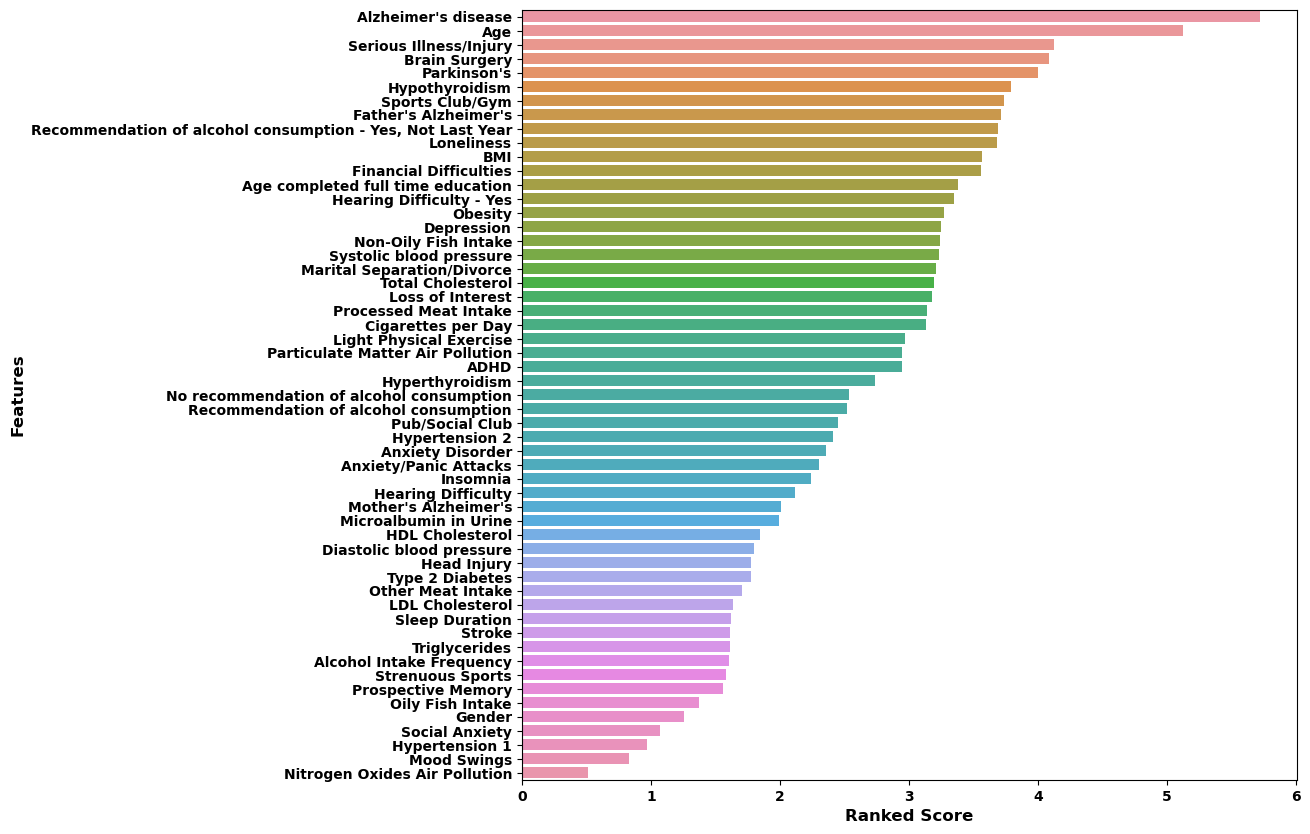

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties


# Extract keys and values
categories = list(sorted_dict.keys())
values = list(sorted_dict.values())

plt.figure(figsize= (10, 10))


    
# Create a bar plot
# plt.barh(categories, values)
ax =sns.barplot(x=values, y=categories, orient='h')
plt.xlabel('Ranked Score', fontweight='bold', fontsize = 12)
plt.ylabel('Features', fontweight='bold', fontsize = 12)
# Make the y-axis categories bold
# ax.set_yt# Make all tick labels bold
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')

# plt.title('Ranked score obtained for each feature in ADNI', fontweight='bold', fontsize = 15)
plt.show()

In [135]:
# Output keys to a file
output_file = "column_importance_ADNI" + progression + ".txt"
with open(output_file, "w") as f:
    for key in sorted_dict.keys():
        f.write(key + "\n")

print("Sorted keys have been written to", output_file)

Sorted keys have been written to column_importance_ADNI.txt


# Run XGBoost for each subset of features

In [136]:
# Read from the output file and store keys in a list
input_file = "column_importance_ADNI" + progression + ".txt"
col_imp = []

with open(input_file, "r") as f:
    for line in f:
        key = line.strip()  # Remove newline character
        col_imp.append(key)

print("Keys read from the file:", col_imp)

Keys read from the file: ["Alzheimer's disease", 'Age', 'Serious Illness/Injury', 'Brain Surgery', "Parkinson's", 'Hypothyroidism', 'Sports Club/Gym', "Father's Alzheimer's", 'Recommendation of alcohol consumption - Yes, Not Last Year', 'Loneliness', 'BMI', 'Financial Difficulties', 'Age completed full time education', 'Hearing Difficulty - Yes', 'Obesity', 'Depression', 'Non-Oily Fish Intake', 'Systolic blood pressure', 'Marital Separation/Divorce', 'Total Cholesterol', 'Loss of Interest', 'Processed Meat Intake', 'Cigarettes per Day', 'Light Physical Exercise', 'Particulate Matter Air Pollution', 'ADHD', 'Hyperthyroidism', 'No recommendation of alcohol consumption', 'Recommendation of alcohol consumption', 'Pub/Social Club', 'Hypertension 2', 'Anxiety Disorder', 'Anxiety/Panic Attacks', 'Insomnia', 'Hearing Difficulty', "Mother's Alzheimer's", 'Microalbumin in Urine', 'HDL Cholesterol', 'Diastolic blood pressure', 'Head Injury', 'Type 2 Diabetes', 'Other Meat Intake', 'LDL Cholestero

In [137]:
shuffled_data = pd.read_csv('adni_shuffled_balanced_6yrs.csv')
if progression != "":
    print("Hello")
    shuffled_data = pd.read_csv('adni_shuffled_balanced_4yrs_' + progression + '.csv')
shuffled_data = shuffled_data.drop(['Unnamed: 0'], axis = 1)

In [138]:
print(shuffled_data.shape)
print( shuffled_data.columns)

(464, 56)
Index(['Type 2 Diabetes', 'No recommendation of alcohol consumption',
       'Recommendation of alcohol consumption - Yes, Not Last Year',
       'Recommendation of alcohol consumption', 'Total Cholesterol',
       'HDL Cholesterol', 'LDL Cholesterol', 'Triglycerides',
       'Cigarettes per Day', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Hearing Difficulty - Yes', 'Depression',
       'Non-Oily Fish Intake', 'Hearing Difficulty', 'BMI', 'Oily Fish Intake',
       'Insomnia', 'Sleep Duration', 'Age completed full time education',
       'Processed Meat Intake', 'Strenuous Sports', 'Other Meat Intake',
       'Loneliness', 'Father's Alzheimer's', 'Mother's Alzheimer's',
       'Mood Swings', 'Anxiety/Panic Attacks', 'Stroke', 'Head Injury',
       'Alcohol Intake Frequency', 'Obesity', 'Hypothyroidism',
       'Hyperthyroidism', 'Hypertension 2', 'Particulate Matter Air Pollution',
       'Nitrogen Oxides Air Pollution', 'Light Physical Exercise',
       '

In [139]:

column_len = len(shuffled_data.columns)
print(column_len)
# dropping last / output column in df
shuffled_data_X = shuffled.iloc[: , :-1]
print(shuffled_X.columns)
# taking the output column of df
shuffled_Y = shuffled.iloc[: , -1]

56
Index(['Type 2 Diabetes', 'No recommendation of alcohol consumption',
       'Recommendation of alcohol consumption - Yes, Not Last Year',
       'Recommendation of alcohol consumption', 'Total Cholesterol',
       'HDL Cholesterol', 'LDL Cholesterol', 'Triglycerides',
       'Cigarettes per Day', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Hearing Difficulty - Yes', 'Depression',
       'Non-Oily Fish Intake', 'Hearing Difficulty', 'BMI', 'Oily Fish Intake',
       'Insomnia', 'Sleep Duration', 'Age completed full time education',
       'Processed Meat Intake', 'Strenuous Sports', 'Other Meat Intake',
       'Loneliness', 'Father's Alzheimer's', 'Mother's Alzheimer's',
       'Mood Swings', 'Anxiety/Panic Attacks', 'Stroke', 'Head Injury',
       'Alcohol Intake Frequency', 'Obesity', 'Hypothyroidism',
       'Hyperthyroidism', 'Hypertension 2', 'Particulate Matter Air Pollution',
       'Nitrogen Oxides Air Pollution', 'Light Physical Exercise',
       'Hyperte

In [140]:
def GetScores(true,pred_binary,pred):
    print(true.shape,pred_binary.shape,pred.shape)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()


#     print("precision",precision[1],"recall", recall[1], "fscore",fscore[1], "auroc", auroc,"auprc", auprc,"accuracy" ,acc)
#     return precision[1], recall[1], fscore[1], auroc, auprc, acc
    return acc,precision[1], recall[1],fscore[1], auroc, auprc

In [141]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import shap
from sklearn.model_selection import KFold 

total_folds = 10
kf = KFold(n_splits = total_folds, random_state=None)



# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
features_len = len(shuffled_X.columns)
results_list = []

max_auroc = 0
best_feat_count = -1

for  i in range( features_len ):
    selected_features = col_imp[:i+1]
#     print(selected_features)
    shuffled_X = shuffled_data_X[selected_features]
#     print(shuffled_X.columns)
#     training_features, testing_features, training_target, testing_target = \
#                 train_test_split(shuffled_X, shuffled_Y, random_state=1)
#     print("training_features",training_features.shape)
#     print("testing_features",testing_features.shape)

    # Average CV score on the training set was: 0.6719885773624091
    exported_pipeline = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=1, min_samples_leaf=7, min_samples_split=6, n_estimators=100, subsample=0.45)
    # Fix random state in exported estimator
    accuracies=[]
    precisions=[]
    recalls=[]
    fscores=[]
    aurocs=[]
    auprcs=[]
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', random_seed)

    for train_index , test_index in kf.split(shuffled):
        X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
        y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]

        exported_pipeline.fit(X_train, y_train)
        y_pred = exported_pipeline.predict(X_test)

        true=y_test
        pred_binary=y_pred
        pred=exported_pipeline.predict_proba(X_test).T
        pred=pred[1]
        acc,precision, recall,fscore, auroc, auprc=GetScores(true,pred_binary,pred)

        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)
        aurocs.append(auroc)
        auprcs.append(auprc)
    avg_acc=np.mean(accuracies)
    avg_prec=np.mean(precisions)
    avg_rec=np.mean(recalls)
    avg_fsc=np.mean(fscores)
    avg_roc=np.mean(aurocs)
    avg_prc=np.mean(auprcs)
    
    if avg_roc > max_auroc:
        max_auroc = avg_roc
        best_feat_count = i + 1
        
        
        


#     # Average CV score on the training set was: 0.6719885773624091
#     exported_pipeline = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=1, min_samples_leaf=7, min_samples_split=6, n_estimators=100, subsample=0.45)
#     # Fix random state in exported estimator
#     if hasattr(exported_pipeline, 'random_state'):
#         setattr(exported_pipeline, 'random_state', 1)

#     exported_pipeline.fit(training_features, training_target)
#     results = exported_pipeline.predict(testing_features)

#     true=testing_target
#     pred_binary=results
#     pred=exported_pipeline.predict_proba(testing_features).T
#     pred=pred[1]
#     precision, recall, fscore, auroc, auprc, acc = GetScores(true,pred_binary,pred)
    results_list.append([i + 1,avg_acc,  avg_prec, avg_rec,avg_prc, avg_roc, avg_fsc])
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list, columns=['Feature_Length', 'Accuracy', 'Precision', 'Recall', 'AUPRC', 'AUROC', 'F1_Score'])

# Write the DataFrame to a CSV file
output_csv_file = "feature_selection_results" + progression + ".csv"
results_df.to_csv(output_csv_file, index=False)
print("Count of best features:", best_feat_count)


#     explainer = shap.TreeExplainer(exported_pipeline)
#     shap_values = explainer.shap_values(training_features)

#     shap.force_plot(explainer.expected_value, shap_values[0,:], training_features.iloc[0,:])


(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,)

(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(116,) (116,) (116,)
(116,) (116,) (116,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,) (115,)
(115,) (115,)

In [142]:
filename = "ADNI_feature_count.txt"
if progression != "":
    filename = "ADNI_feature_count_" + progression + '.txt'

#w tells python we are opening the file to write into it
outfile = open(filename, 'w')

outfile.write(str(best_feat_count))

outfile.close() #Close the file when we’re done!


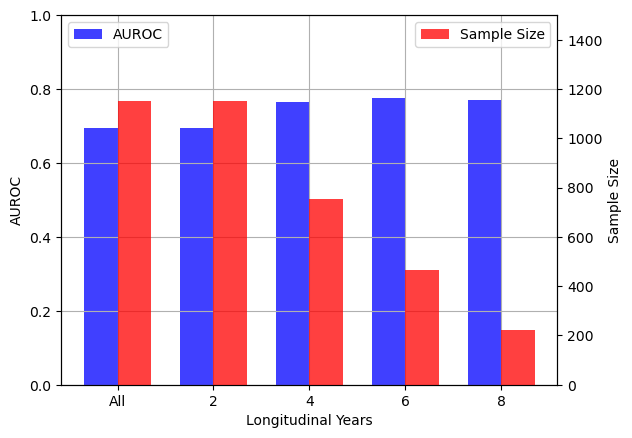

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
categories = ['All', 2, 4, 6, 8]
values1 = [0.694, 0.694,0.765, 0.777, 0.771]
values2 = [1152, 1152, 754, 464, 222]

# Create subplots
fig, ax1 = plt.subplots()

# Define the second y-axis
ax2 = ax1.twinx()

# Width of each bar
bar_width = 0.35

# Calculate the x-positions for bars
x1 = np.arange(len(categories))
x2 = [x + bar_width for x in x1]

# Create bar plots on each subplot
bar1 = ax1.bar(x1, values1, width=bar_width, color='b', alpha=0.75, label='AUROC')
bar2 = ax2.bar(x2, values2, width=bar_width, color='r', alpha=0.75, label='Sample Size')

# Set labels for x-axis and each y-axis
ax1.set_xlabel('Longitudinal Years')
ax1.set_ylabel('AUROC')
ax2.set_ylabel('Sample Size')

# Customize appearance
ax1.set_xticks(x1 + bar_width / 2)
ax1.set_xticklabels(categories)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set y-axis limits
ax1.set_ylim(0.0, 1.0)  # Adjust the limits for the first y-axis
ax2.set_ylim(0, 1500)

ax2.grid(False)
ax1.grid(True)

# Show the plot
# plt.title('ADNI : Longitudinal Analysis')
plt.show()


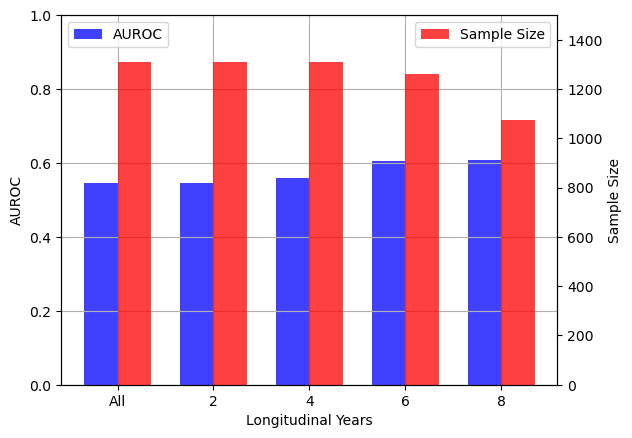

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
categories = ['All', 2, 4, 6, 8]
values1 = [0.544754389, 0.544754389, 0.559698591, 0.604346748, 0.607585079]
values2 = [1310, 1310, 1310, 1262, 1074]

# Create subplots
fig, ax1 = plt.subplots()

# Define the second y-axis
ax2 = ax1.twinx()

# Width of each bar
bar_width = 0.35

# Calculate the x-positions for bars
x1 = np.arange(len(categories))
x2 = [x + bar_width for x in x1]

# Create bar plots on each subplot
bar1 = ax1.bar(x1, values1, width=bar_width, color='b', alpha=0.75, label='AUROC')
bar2 = ax2.bar(x2, values2, width=bar_width, color='r', alpha=0.75, label='Sample Size')

# Set labels for x-axis and each y-axis
ax1.set_xlabel('Longitudinal Years')
ax1.set_ylabel('AUROC')
ax2.set_ylabel('Sample Size')

# Customize appearance
ax1.set_xticks(x1 + bar_width / 2)
ax1.set_xticklabels(categories)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set y-axis limits
ax1.set_ylim(0.0, 1.0)  # Adjust the limits for the first y-axis
ax2.set_ylim(0, 1500)

ax2.grid(False)
ax1.grid(True)

# Show the plot
# plt.title('ROSMAP : Longitudinal Analysis')
plt.show()
